# FIRE Framework: Functional Infrastructure Resilience Evaluation
## OFC 2025 Conference Submission

**Topology is Not Enough: Functional Resilience Under Probabilistic Node and Link Attacks**

This notebook implements the complete FIRE methodology including:
1. Data Curation - Topology-to-function mapping for US, India, and UK networks
2. Functional Metrics - Service Continuity, Coverage, Diversity, Stability
3. Baseline Metrics - Algebraic Connectivity, LCC, Global Efficiency, Graph Energy
4. Monte Carlo Attack-Recovery Simulations (n=50 runs)



Akanksha Ahuja

---


## 1. Core Functions: Function Placement Generation

---



---



Good placement: Distributed using K-means clustering  
Poor placement: Centralized strategy


In [1]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
import math
from topologybench import *
from bt_topology import *

import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import networkx as nx
from typing import Dict, List, Tuple, Optional, Set
from scipy.spatial.distance import jensenshannon
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm


# ignore warnings
import warnings
warnings.filterwarnings("ignore")




In [2]:
# =============================================================================
# Core Components of Light Bench
# =============================================================================

@dataclass
class FunctionDef:
    """Describes a function in the LightBench catalogue."""
    name: str
    importance: float
    base_prob: float

@dataclass
class PlacementPolicy:
    """Policy knobs that steer the probabilistic placement and coverage guarantees."""
    role_bias: Dict[str, Dict[str, float]] = field(default_factory=dict)
    gold_threshold: float = 0.90
    min_clusters_for_gold: int = 2
    min_global_replicas: Dict[str, int] = field(
        default_factory=lambda: {"optical_control_plane": 3}
    )

@dataclass
class PoorPlacementConfig:
    """Configuration for poor placement strategies."""
    strategy: str = "centralized"  # Only centralized for this project
    centralization_factor: float = 0.2  # Fraction of nodes to concentrate functions on

@dataclass
class BuildConfig:
    """All configuration for a LightBench build in one place."""
    # Coordinates
    lat_attr: str = "lat"
    lon_attr: str = "lon"

    # Regions (k-means clusters by lat/lon)
    n_regions: int = 4

    # Role mix
    role_probs: Dict[str, float] = field(
        default_factory=lambda: {"DC": 0.12, "IXP": 0.08, "CR": 0.45, "ER": 0.35}
    )

    # Optical edge parameters
    capacity_tiers_gbps_per_lambda: Tuple[int, ...] = (100, 200, 400, 600, 800)
    wavelength_slots_range: Tuple[int, int] = (40, 96)
    span_km: float = 80.0

    # Function catalogue & placement policy
    functions: List[FunctionDef] = field(default_factory=list)
    placement: PlacementPolicy = field(default_factory=lambda: default_policy_optical())

    # Poor placement config (None for good placement)
    poor_placement: Optional[PoorPlacementConfig] = None

    # RNG + I/O
    seed: Optional[int] = 42
    output_dir: Optional[str] = None

# =============================================================================
# Default Functions and Policies
# =============================================================================

def default_functions_optical() -> List[FunctionDef]:
    """Optical-first function set."""
    return [
        # Core optical functions
        FunctionDef("lambda_routing",        importance=0.95, base_prob=1.0),
        FunctionDef("optical_control_plane", importance=0.92, base_prob=0.25),
        FunctionDef("pce",                   importance=0.91, base_prob=0.20),
        FunctionDef("protection_switching",  importance=0.80, base_prob=0.30),
        FunctionDef("restoration",           importance=0.78, base_prob=0.25),
        FunctionDef("regeneration",          importance=0.75, base_prob=0.15),
        FunctionDef("wavelength_conversion", importance=0.72, base_prob=0.15),
        FunctionDef("spectrum_defragmentation", importance=0.70, base_prob=0.20),
        FunctionDef("otn_grooming",          importance=0.70, base_prob=0.20),

        # Monitoring/OAM
        FunctionDef("optical_telemetry",     importance=0.65, base_prob=0.25),
        FunctionDef("otdr_fault_loc",        importance=0.60, base_prob=0.20),

        # Inter-domain
        FunctionDef("optical_peering",       importance=0.90, base_prob=0.18),

        # Optional overlays
        FunctionDef("caching",               importance=0.55, base_prob=0.20),
        FunctionDef("ddos_scrubbing",        importance=0.50, base_prob=0.16),
        FunctionDef("l1_encryption",         importance=0.50, base_prob=0.15),
        FunctionDef("storage",               importance=0.58, base_prob=0.22),
        FunctionDef("dns_aaa",               importance=0.90, base_prob=0.20),
    ]

def default_policy_optical() -> PlacementPolicy:
    """Role biases for optical placement."""
    role_bias = {
        "DC": {
            "optical_control_plane": 0.15,
            "pce": 0.15,
            "optical_telemetry": 0.15,
            "caching": 0.25,
            "ddos_scrubbing": 0.20,
            "l1_encryption": 0.20,
            "spectrum_defragmentation": 0.10,
            "otn_grooming": 0.15,
            "optical_peering": 0.15,
            "storage": 0.25,
            "dns_aaa": 0.20,
        },
        "IXP": {
            "optical_peering": 0.30,
            "ddos_scrubbing": 0.15,
            "caching": 0.15,
            "optical_telemetry": 0.10,
            "dns_aaa": 0.15,
        },
        "CR": {
            "optical_control_plane": 0.10,
            "pce": 0.10,
            "protection_switching": 0.20,
            "restoration": 0.20,
            "regeneration": 0.15,
            "wavelength_conversion": 0.15,
            "spectrum_defragmentation": 0.10,
            "otn_grooming": 0.10,
            "dns_aaa": 0.15,
        },
        "ER": {
            "optical_telemetry": 0.10,
            "otdr_fault_loc": 0.10,
        },
    }
    return PlacementPolicy(
        role_bias=role_bias,
        gold_threshold=0.90,
        min_clusters_for_gold=2,
        min_global_replicas={
            "optical_control_plane": 3,
            "pce": 3,
            "optical_peering": 3,
            "dns_aaa": 4,
        },
    )

# =============================================================================
# Utility Functions
# =============================================================================

def _rng(seed: Optional[int]) -> np.random.Generator:
    """Return a NumPy RNG that honours 'seed'."""
    return np.random.default_rng(seed) if seed is not None else np.random.default_rng()

def haversine_km(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Great-circle distance in kilometres."""
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(p1) * math.cos(p2) * math.sin(dlmb / 2) ** 2
    return 2 * R * math.asin(math.sqrt(a))

def ensure_positions(G: nx.Graph, lat_attr: str, lon_attr: str, seed: Optional[int]) -> None:
    """Ensure every node has coordinates."""
    need_positions = any(lat_attr not in G.nodes[n] or lon_attr not in G.nodes[n] for n in G.nodes)
    if not need_positions:
        return
    pos = nx.spring_layout(G, seed=seed)
    for n, (x, y) in pos.items():
        G.nodes[n][lat_attr] = 50.0 + 5.0 * y
        G.nodes[n][lon_attr] = 0.0 + 5.0 * x

def kmeans_regions(points: np.ndarray, k: int, seed: Optional[int], iters: int = 25) -> np.ndarray:
    """Simple k-means implementation."""
    rng = _rng(seed)
    assert len(points) >= k, "k-means requires points >= k"
    centers = points[rng.choice(len(points), size=k, replace=False)]
    for _ in range(iters):
        dists = np.linalg.norm(points[:, None, :] - centers[None, :, :], axis=2)
        labels = dists.argmin(axis=1)
        for i in range(k):
            mask = labels == i
            centers[i] = points[mask].mean(axis=0) if mask.any() else points[rng.integers(0, len(points))]
    return labels

def assign_regions(G: nx.Graph, lat_attr: str, lon_attr: str, n_regions: int, seed: Optional[int]) -> None:
    """Run k-means over (lat, lon) and set node['region']."""
    pts = np.array([[G.nodes[n][lat_attr], G.nodes[n][lon_attr]] for n in G.nodes])
    labels = kmeans_regions(pts, n_regions, seed)
    for (n, lbl) in zip(G.nodes, labels):
        G.nodes[n]["region"] = f"R{lbl + 1}"

def assign_roles(G: nx.Graph, role_probs: Dict[str, float], seed: Optional[int]) -> None:
    """Assign a single dominant role per node."""
    deg_cent = nx.degree_centrality(G)
    try:
        bet_cent = nx.betweenness_centrality(G, seed=seed)
    except TypeError:
        bet_cent = nx.betweenness_centrality(G)

    score = {n: 0.6 * deg_cent.get(n, 0.0) + 0.4 * bet_cent.get(n, 0.0) for n in G.nodes}

    N = G.number_of_nodes()
    counts = {role: int(round(p * N)) for role, p in role_probs.items()}

    # Adjust rounding
    diff = N - sum(counts.values())
    for role in sorted(role_probs, key=role_probs.get, reverse=True):
        if diff == 0:
            break
        counts[role] += 1 if diff > 0 else -1
        diff = N - sum(counts.values())

    ranked = sorted(score.items(), key=lambda kv: kv[1], reverse=True)
    idx = 0
    for role in ["DC", "IXP", "CR", "ER"]:
        take = counts.get(role, 0)
        for j in range(take):
            if idx + j < len(ranked):
                G.nodes[ranked[idx + j][0]]["role"] = role
        idx += take

    for n in G.nodes:
        G.nodes[n].setdefault("role", "ER")

def compute_edge_metrics(
    G: nx.Graph,
    lat_attr: str,
    lon_attr: str,
    capacity_tiers_gbps_per_lambda: Tuple[int, ...],
    wavelength_slots_range: Tuple[int, int],
    span_km: float,
    seed: Optional[int],
) -> None:
    """Populate optical metrics on edges if missing."""
    rng = _rng(seed)
    for u, v, data in G.edges(data=True):
        # Length
        lat1, lon1 = G.nodes[u][lat_attr], G.nodes[u][lon_attr]
        lat2, lon2 = G.nodes[v][lat_attr], G.nodes[v][lon_attr]
        length_km = data.get("length_km")
        if length_km is None:
            length_km = haversine_km(lat1, lon1, lat2, lon2)
            data["length_km"] = float(length_km)

        # Per-λ capacity
        per_lambda = data.get("capacity_gbps_per_lambda")
        if per_lambda is None:
            per_lambda = int(rng.choice(capacity_tiers_gbps_per_lambda))
            data["capacity_gbps_per_lambda"] = per_lambda

        # Slots and occupancy
        if "wavelength_slots" not in data:
            slots = int(rng.integers(wavelength_slots_range[0], wavelength_slots_range[1] + 1))
            data["wavelength_slots"] = slots
            avail = int(max(0, rng.uniform(0.5, 0.9) * slots))
            data["available_slots"] = avail

        # Spans and amplifiers
        if "estimated_spans" not in data:
            spans = max(1, int(math.ceil(length_km / span_km)))
            data["estimated_spans"] = spans
            data["amplifier_count"] = max(0, spans - 1)

        # Aggregate line capacity
        if "total_line_capacity_gbps" not in data:
            data["total_line_capacity_gbps"] = int(data["wavelength_slots"] * per_lambda)

def _node_long_link_incidence(G: nx.Graph, threshold_km: float = 200.0) -> Dict:
    """Count how many incident links are long for each node."""
    cnt = {n: 0 for n in G.nodes}
    for u, v, d in G.edges(data=True):
        if d.get("length_km", 0.0) >= threshold_km:
            cnt[u] += 1
            cnt[v] += 1
    return cnt

# =============================================================================
# Good and Poor Function Placement
# =============================================================================

def place_functions_good(
    G: nx.Graph,
    functions: List[FunctionDef],
    policy: PlacementPolicy,
    seed: Optional[int],
) -> Dict[Tuple, int]:
    """Original good placement logic."""
    rng = _rng(seed)
    placement: Dict[Tuple, int] = {}

    # Deterministic λ-routing on all nodes
    has_lambda = any(f.name == "lambda_routing" for f in functions)
    if has_lambda:
        for n in G.nodes:
            placement[(n, "lambda_routing")] = 1

    # Precompute topology bias for regeneration
    long_incidence = _node_long_link_incidence(G, threshold_km=200.0)

    # Sample other functions
    for f in functions:
        if f.name == "lambda_routing":
            continue
        for n in G.nodes:
            role = G.nodes[n].get("role", "ER")
            p = f.base_prob
            p += policy.role_bias.get(role, {}).get(f.name, 0.0)

            if f.name == "regeneration":
                p += min(0.30, 0.05 * long_incidence.get(n, 0))

            p = float(np.clip(p, 0.01, 0.98))
            if rng.random() < p:
                placement[(n, f.name)] = placement.get((n, f.name), 0) + 1
                if role == "DC" and rng.random() < 0.15:
                    placement[(n, f.name)] += 1

    # Enforce minimum global replicas
    for func, k in (policy.min_global_replicas or {}).items():
        hosts = [n for (n, fn) in placement if fn == func]
        if len(hosts) < k:
            degs = dict(G.degree())
            candidates = sorted(
                (n for n in G.nodes if (n, func) not in placement),
                key=lambda n: degs.get(n, 0),
                reverse=True,
            )
            for n in candidates[: max(0, k - len(hosts))]:
                placement[(n, func)] = 1

    # Enforce gold functions across regions
    gold_funcs = [f.name for f in functions if f.importance >= policy.gold_threshold]
    node_region = {n: G.nodes[n].get("region", "R?") for n in G.nodes}
    all_regions = set(node_region.values())
    degs = dict(G.degree())

    for func in gold_funcs:
        hosted_regions = {node_region[n] for (n, fn) in placement if fn == func}
        if len(hosted_regions) >= policy.min_clusters_for_gold:
            continue
        missing = list(all_regions - hosted_regions)
        regions_needed = policy.min_clusters_for_gold - len(hosted_regions)
        for r in missing[:regions_needed]:
            region_nodes = [n for n in G.nodes if node_region[n] == r and (n, func) not in placement]
            if not region_nodes:
                continue
            best = max(region_nodes, key=lambda n: degs.get(n, 0))
            placement[(best, func)] = placement.get((best, func), 0) + 1

    return placement

def place_functions(
    G: nx.Graph,
    functions: List[FunctionDef],
    policy: PlacementPolicy,
    poor_config: Optional[PoorPlacementConfig],
    seed: Optional[int],
) -> Dict[Tuple, int]:
    """Route to good or poor placement based on config."""
    if poor_config is None:
        return place_functions_good(G, functions, policy, seed)
    elif poor_config.strategy == "centralized":
        return place_functions_poor_centralized(
            G, functions, poor_config.centralization_factor, seed
        )
    else:
        raise ValueError(f"Unknown poor placement strategy: {poor_config.strategy}")

# =============================================================================
# Main Build Function
# =============================================================================

def build_lightbench_data(G: nx.Graph, cfg: Optional[BuildConfig] = None) -> Dict[str, pd.DataFrame]:
    """Build LightBench dataset frames from a NetworkX graph."""
    cfg = cfg or BuildConfig()
    if not cfg.functions:
        cfg.functions = default_functions_optical()

    # Work on a copy
    H = G.copy()

    # 1) Ensure node coordinates exist
    ensure_positions(H, cfg.lat_attr, cfg.lon_attr, cfg.seed)

    # 2) Assign region labels
    assign_regions(H, cfg.lat_attr, cfg.lon_attr, cfg.n_regions, cfg.seed)

    # 3) Assign roles
    assign_roles(H, cfg.role_probs, cfg.seed)

    # 4) Fill optical edge metrics
    compute_edge_metrics(
        H,
        cfg.lat_attr,
        cfg.lon_attr,
        cfg.capacity_tiers_gbps_per_lambda,
        cfg.wavelength_slots_range,
        cfg.span_km,
        cfg.seed,
    )

    # 5) Place functions (good or poor)
    placement = place_functions(H, cfg.functions, cfg.placement, cfg.poor_placement, cfg.seed)

    # 6) Build the four tidy frames
    nd_rows = []
    degs = dict(H.degree())
    for n in H.nodes:
        nd_rows.append({
            "id": n,
            "lat": H.nodes[n][cfg.lat_attr],
            "lon": H.nodes[n][cfg.lon_attr],
            "region": H.nodes[n].get("region"),
            "role": H.nodes[n].get("role"),
            "degree": degs.get(n, 0),
        })
    nodes_df = pd.DataFrame(nd_rows)

    ed_rows = []
    for u, v, d in H.edges(data=True):
        ed_rows.append({
            "u": u,
            "v": v,
            "length_km": float(d.get("length_km", np.nan)),
            "capacity_gbps_per_lambda": int(d.get("capacity_gbps_per_lambda", 0)),
            "wavelength_slots": int(d.get("wavelength_slots", 0)),
            "available_slots": int(d.get("available_slots", 0)),
            "estimated_spans": int(d.get("estimated_spans", 0)),
            "amplifier_count": int(d.get("amplifier_count", 0)),
            "total_line_capacity_gbps": int(d.get("total_line_capacity_gbps", 0)),
        })
    edges_df = pd.DataFrame(ed_rows)

    functions_df = pd.DataFrame(
        [{"function": f.name, "importance": f.importance} for f in cfg.functions]
    )

    fp_rows = [{"node_id": n, "function": fn, "count": c}
               for (n, fn), c in placement.items() if c > 0]
    function_placement_df = pd.DataFrame(fp_rows)

    # Optional CSV export
    if cfg.output_dir:
        import os
        os.makedirs(cfg.output_dir, exist_ok=True)
        nodes_df.to_csv(os.path.join(cfg.output_dir, "nodes.csv"), index=False)
        edges_df.to_csv(os.path.join(cfg.output_dir, "edges.csv"), index=False)
        functions_df.to_csv(os.path.join(cfg.output_dir, "functions.csv"), index=False)
        function_placement_df.to_csv(os.path.join(cfg.output_dir, "function_placement.csv"), index=False)

    return {
        "nodes": nodes_df,
        "edges": edges_df,
        "functions": functions_df,
        "function_placement": function_placement_df,
    }



def place_functions_poor_centralized(
    G: nx.Graph,
    functions: List[FunctionDef],
    centralization_factor: float,
    seed: Optional[int],
    *,
    target_counts: Optional[Dict[str, int]] = None,  # per-function totals to match (from the good run)
) -> Dict[Tuple, int]:
    """
    Very centralized 'poor' placement.
    - Concentrate on top-k degree nodes (k = ceil(factor * N)).
    - p_central ~ 1, p_off ~ 0.
    - Optionally match total counts per function to 'target_counts' (recommended).
    """
    rng = _rng(seed)
    placement: Dict[Tuple, int] = {}

    # λ-routing everywhere (unchanged)
    if any(f.name == "lambda_routing" for f in functions):
        for n in G.nodes:
            placement[(n, "lambda_routing")] = 1

    # choose central set
    degs = dict(G.degree())
    nodes_sorted = sorted(G.nodes, key=lambda n: degs.get(n, 0), reverse=True)
    k = max(1, int(np.ceil(centralization_factor * len(nodes_sorted))))
    central = nodes_sorted[:k]
    off_central = nodes_sorted[k:]

    for f in functions:
        if f.name == "lambda_routing":
            continue

        # ---- sampling probabilities (harsh) ----
        p_c = min(0.995, 6.0 * f.base_prob)           # near-certain on hubs
        p_o = min(0.02, 0.02 * f.base_prob)           # almost absent elsewhere

        # initial stochastic placement
        hosts = []

        # central nodes
        for n in central:
            if rng.random() < p_c:
                hosts.append(n)
                # extra replicas make hubs even "heavier"
                if rng.random() < 0.60:
                    placement[(n, f.name)] = placement.get((n, f.name), 0) + 2
                else:
                    placement[(n, f.name)] = placement.get((n, f.name), 0) + 1

        # off-central nodes (thin background)
        for n in off_central:
            if rng.random() < p_o:
                placement[(n, f.name)] = placement.get((n, f.name), 0) + 1

        # ---- optional count matching to 'good' totals ----
        if target_counts is not None and f.name in target_counts:
            want = int(target_counts[f.name])
            have = sum(c for (n, fn), c in placement.items() if fn == f.name)
            if have < want:
                # add the shortfall on central nodes (most vulnerable)
                need = want - have
                pool = np.array(central, dtype=object)
                # weight by degree so we pile onto the most connected hubs
                w = np.array([degs[n] for n in pool], float)
                w = (w / (w.sum() + 1e-12)) if w.sum() > 0 else np.ones_like(w)/len(w)
                picks = rng.choice(pool, size=need, replace=True, p=w)
                for n in picks:
                    placement[(n, f.name)] = placement.get((n, f.name), 0) + 1
            elif have > want:
                # randomly trim off-central first, then central
                extra = have - want
                # build list of unit-instances [(n,f)] for removal
                units = []
                for (n, fn), c in list(placement.items()):
                    if fn == f.name:
                        units += [(n, fn)] * c
                # prefer removing off-central
                units_off = [u for u in units if u[0] in off_central]
                units_cen = [u for u in units if u[0] in central]
                for ulist in (units_off, units_cen):
                    rng.shuffle(ulist)
                    while extra > 0 and ulist:
                        n, fn = ulist.pop()
                        placement[(n, fn)] -= 1
                        if placement[(n, fn)] <= 0:
                            del placement[(n, fn)]
                        extra -= 1
                    if extra <= 0:
                        break

    return placement



# =============================================================================
# Functional Distribution Score (FDS) utilities
# =============================================================================

def _gini(x: np.ndarray) -> float:
    """Gini coefficient in [0,1] for non-negative x."""
    x = np.asarray(x, float)
    n = x.size
    if n == 0:
        return 0.0
    if np.all(x == 0):
        return 0.0
    x = np.sort(x)
    cum = np.cumsum(x)
    S = cum[-1]
    # Correct formula:
    # G = (2 * sum_{i=1}^n i*x_i) / (n*S) - (n+1)/n
    return float((2.0 * np.sum((np.arange(1, n+1) * x))) / (n * S) - (n + 1.0) / n)

def _normalized_hhi(shares: np.ndarray) -> float:
    """HHI normalized to [0,1]: (HHI - 1/N) / (1 - 1/N)."""
    shares = np.asarray(shares, float)
    N = shares.size
    if N == 0:
        return 0.0
    hhi = float(np.sum(shares**2))
    return float((hhi - 1.0/N) / (1.0 - 1.0/N + EPS))

def _normalized_entropy(shares: np.ndarray) -> float:
    """Shannon entropy normalized to [0,1]."""
    p = np.asarray(shares, float)
    p = p[p > 0]
    if p.size == 0:
        return 0.0
    H = -np.sum(p * np.log(p + EPS))
    Hmax = np.log(len(shares)) if len(shares) > 0 else 1.0
    return float(H / (Hmax + EPS))

def compute_functional_distribution_tables(
    nodes_df: pd.DataFrame,
    placement_df: pd.DataFrame,
    functions_df: pd.DataFrame,
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Returns:
      node_fds_df: per-node table with functional load, share, and FDS-node
      summary: dict with network-level FDS metrics (Entropy, HHI, Gini)
    """
    # Sum importance*count per node
    imp_map = functions_df.set_index("function")["importance"].to_dict()

    # Expand placement with importance
    p = placement_df.copy()
    p["importance"] = p["function"].map(imp_map).fillna(0.0)
    p["load_contrib"] = p["count"] * p["importance"]

    node_load = p.groupby("node_id")["load_contrib"].sum().rename("func_load")
    node_funcs = p.groupby("node_id")["function"].nunique().rename("distinct_functions")

    out = nodes_df[["id", "degree"]].copy()
    out = out.merge(node_load, left_on="id", right_index=True, how="left")
    out = out.merge(node_funcs, left_on="id", right_index=True, how="left")
    out["func_load"] = out["func_load"].fillna(0.0)
    out["distinct_functions"] = out["distinct_functions"].fillna(0).astype(int)

    total_load = float(out["func_load"].sum())
    N = len(out)

    if total_load <= 0:
        # No functions placed beyond lambda_routing counted as importance*count
        out["share"] = 0.0
        out["FDS_node"] = 0.0
        summary = dict(FDS_entropy=0.0, HHI_norm=0.0, Gini=0.0)
        return out, summary

    out["share"] = out["func_load"] / total_load

    # Per-node "evenness closeness" in [0,1] (1 means exactly even share = 1/N)
    ideal = 1.0 / max(N, 1)
    out["FDS_node"] = 1.0 - np.abs(out["share"] - ideal) / (1.0 - ideal + EPS)

    # Network-level scores
    shares = out["share"].to_numpy(float)
    FDS_entropy = _normalized_entropy(shares)
    HHI_norm = _normalized_hhi(shares)
    Gini = _gini(out["func_load"].to_numpy(float))

    summary = dict(
        FDS_entropy=float(FDS_entropy),  # higher = more evenly distributed
        HHI_norm=float(HHI_norm),        # higher = more concentrated
        Gini=float(Gini)                 # higher = more unequal
    )
    return out, summary

# =============================================================================
# Functional distribution plots
# =============================================================================

def plot_degree_vs_functional_pdfs(
    node_fds_good: pd.DataFrame,
    node_fds_poor: pd.DataFrame,
    *,
    bins_degree: int = 20,
    bins_load: int = 20,
    figsize=(13, 5),
    title_suffix: str = ""
) -> None:
    """
    Panel (A): Degree PDFs (good vs poor; they should coincide since topology fixed)
    Panel (B): Functional load PDFs (good vs poor)
    """
    with plt.rc_context({
        "font.size": 13, "axes.titlesize": 14, "axes.labelsize": 13,
        "legend.fontsize": 12, "xtick.labelsize": 12, "ytick.labelsize": 12
    }):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Degree PDFs
        d_good = node_fds_good["degree"].to_numpy(float)
        d_poor = node_fds_poor["degree"].to_numpy(float)
        ax1.hist(d_good, bins=bins_degree, density=True, alpha=0.45, label="Good — degree")
        ax1.hist(d_poor, bins=bins_degree, density=True, alpha=0.45, label="Poor — degree")
        ax1.set_xlabel("Node degree")
        ax1.set_ylabel("PDF")
        ax1.set_title(f"A. Degree distribution{title_suffix}")
        ax1.grid(True, ls=":", alpha=0.35)
        ax1.legend()

        # Functional load PDFs
        f_good = node_fds_good["func_load"].to_numpy(float)
        f_poor = node_fds_poor["func_load"].to_numpy(float)
        ax2.hist(f_good, bins=bins_load, density=True, alpha=0.45, label="Good — functional load")
        ax2.hist(f_poor, bins=bins_load, density=True, alpha=0.45, label="Poor — functional load")
        ax2.set_xlabel("Per-node functional load  (∑ importance × count)")
        ax2.set_ylabel("PDF")
        ax2.set_title(f"B. Functional load distribution{title_suffix}")
        ax2.grid(True, ls=":", alpha=0.35)
        ax2.legend()

        plt.tight_layout()
        plt.show()



# ---------- KDE utilities ----------
def _kde_curve(x: np.ndarray, *, bw_method: str | float | None = None, npoints: int = 512):
    """Return (grid, pdf) for a 1D gaussian_kde; pdf integrates to ~1."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size < 2:
        # fall back to a delta-ish bump
        g = np.linspace(x.min() - 1, x.max() + 1, npoints) if x.size == 1 else np.linspace(0, 1, npoints)
        pdf = np.zeros_like(g);
        if x.size == 1:
            # put a narrow Gaussian for visibility
            s = np.maximum(np.std(x), 1e-6) or 1e-3
            pdf = np.exp(-0.5*((g - x[0])/s)**2)/(s*np.sqrt(2*np.pi))
            pdf /= np.trapz(pdf, g) + 1e-12
        return g, pdf

    lo, hi = np.min(x), np.max(x)
    pad = 0.05 * (hi - lo + 1e-9)
    g = np.linspace(lo - pad, hi + pad, npoints)
    kde = gaussian_kde(x, bw_method=bw_method)
    pdf = kde(g)
    # normalize exactly
    area = np.trapz(pdf, g)
    if area > 0:
        pdf = pdf / area
    return g, pdf

# ---------- Plot: degree KDE and functional-load KDE ----------
def plot_kde_overlays(
    good_node_fds: pd.DataFrame,
    poor_node_fds: pd.DataFrame,
    *,
    bw_method: str | float | None = "scott",
    npoints: int = 512,
    figsize=(12, 4.8),
    title_suffix: str = ""
):
    """
    Panel A: Degree KDE (good vs poor)
    Panel B: Functional-load KDE (good vs poor)
    All curves normalized to integrate to 1.
    """
    with plt.rc_context({
        "font.size": 12, "axes.titlesize": 13, "axes.labelsize": 12,
        "legend.fontsize": 11, "xtick.labelsize": 11, "ytick.labelsize": 11
    }):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # ---- Degree KDEs
        g_deg = good_node_fds["degree"].to_numpy(float)
        p_deg = poor_node_fds["degree"].to_numpy(float)
        gx, gpdf = _kde_curve(g_deg, bw_method=bw_method, npoints=npoints)
        px, ppdf = _kde_curve(p_deg, bw_method=bw_method, npoints=npoints)
        # unify x-range
        x_min = min(gx.min(), px.min()); x_max = max(gx.max(), px.max())
        gx = np.linspace(x_min, x_max, npoints); gpdf = gaussian_kde(g_deg, bw_method=bw_method)(gx); gpdf /= np.trapz(gpdf, gx)
        px = np.linspace(x_min, x_max, npoints); ppdf = gaussian_kde(p_deg, bw_method=bw_method)(px); ppdf /= np.trapz(ppdf, px)

        ax1.plot(gx, gpdf, label="Good — degree", lw=2)
        ax1.plot(px, ppdf, label="Poor — degree", lw=2, ls="--")
        ax1.set_title(f"A. Degree KDE{title_suffix}")
        ax1.set_xlabel("Node degree")
        ax1.set_ylabel("PDF")
        ax1.grid(True, ls=":", alpha=0.35)
        ax1.legend()

        # ---- Functional-load KDEs
        g_load = good_node_fds["func_load"].to_numpy(float)
        p_load = poor_node_fds["func_load"].to_numpy(float)
        gx2, gpdf2 = _kde_curve(g_load, bw_method=bw_method, npoints=npoints)
        px2, ppdf2 = _kde_curve(p_load, bw_method=bw_method, npoints=npoints)
        x2_min = min(gx2.min(), px2.min()); x2_max = max(gx2.max(), px2.max())
        gx2 = np.linspace(x2_min, x2_max, npoints); gpdf2 = gaussian_kde(g_load, bw_method=bw_method)(gx2); gpdf2 /= np.trapz(gpdf2, gx2)
        px2 = np.linspace(x2_min, x2_max, npoints); ppdf2 = gaussian_kde(p_load, bw_method=bw_method)(px2); ppdf2 /= np.trapz(ppdf2, px2)

        ax2.plot(gx2, gpdf2, label="Good — functional load", lw=2)
        ax2.plot(px2, ppdf2, label="Poor — functional load", lw=2, ls="--")
        ax2.set_title(f"B. Functional-load KDE{title_suffix}")
        ax2.set_xlabel("Per-node functional load (∑ importance × count)")
        ax2.set_ylabel("PDF")
        ax2.grid(True, ls=":", alpha=0.35)
        ax2.legend()

        plt.tight_layout()
        plt.show()



EPS = 1e-9

def get_coronet_network_from_topology_bench():
    # Create topology
    print("\n1. Creating Coronet graph...")
    G = create_coronet_graph()
    print(f"   Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G


def create_functional_attributed_graph_data(G):
    print("="*70)
    print("Comparing good vs poor function placement")
    print("="*70)

    # 2. Generate good placement
    print("\n2. Generating GOOD function placement...")
    cfg_good = BuildConfig(
        n_regions=4,
        seed=42,
        poor_placement=None  # This ensures good placement
    )
    cfg_good.functions = default_functions_optical()
    cfg_good.placement = default_policy_optical()

    good_data = build_lightbench_data(G, cfg_good)
    good_placements = good_data["function_placement"]["count"].sum()
    good_functions = good_data["function_placement"]["function"].nunique()
    good_nodes = good_data["function_placement"]["node_id"].nunique()

    print(f"   Good placement: {good_placements} total placements")
    print(f"   Functions deployed: {good_functions}")
    print(f"   Nodes with functions: {good_nodes}")


    # 3. Generate poor placement (centralized)
    print("\n3. Generating POOR function placement (centralized strategy)...")
    cfg_poor = BuildConfig(
        n_regions=4,
        seed=42,
        poor_placement=PoorPlacementConfig(
            strategy="centralized",
            centralization_factor=0.15  # Concentrate on 15% of nodes
        )
    )
    cfg_poor.functions = default_functions_optical()
    cfg_poor.placement = default_policy_optical()

    poor_data = build_lightbench_data(G, cfg_poor)
    poor_placements = poor_data["function_placement"]["count"].sum()
    poor_functions = poor_data["function_placement"]["function"].nunique()
    poor_nodes = poor_data["function_placement"]["node_id"].nunique()

    print(f"   Poor placement: {poor_placements} total placements")
    print(f"   Functions deployed: {poor_functions}")
    print(f"   Nodes with functions: {poor_nodes}")

    # ---- Compute per-node tables + network FDS summaries
    good_node_fds, good_summary = compute_functional_distribution_tables(
        good_data["nodes"], good_data["function_placement"], good_data["functions"]
    )
    poor_node_fds, poor_summary = compute_functional_distribution_tables(
        poor_data["nodes"], poor_data["function_placement"], poor_data["functions"]
    )

    print("\nFunctional Distribution — Network summaries")
    print("Good:", good_summary)
    print("Poor:", poor_summary)

    # ---- PDFs: degree vs functional load (good vs poor)
    plot_degree_vs_functional_pdfs(
        good_node_fds, poor_node_fds, title_suffix=""
    )

    plot_kde_overlays(
    good_node_fds, poor_node_fds,
    bw_method="scott",
    npoints=512,
    title_suffix=""
    )

    return good_data, poor_data




## 2. Core Functions: FIRE Metrics Implementation

**Functional Metrics:**
- Service Continuity: Function availability after failure
- Service Coverage: Geographic coverage preservation
- Service Diversity: Distribution across regions
- Service Stability: Placement consistency

**Baseline Metrics:**
- Algebraic Connectivity
- Largest Connected Component (LCC)
- Global Efficiency
- Graph Energy


In [3]:
# =============================================================================
# 1. PROBABILISTIC ATTACK FUNCTIONS
# =============================================================================

def sample_node_failure_order(
    G: nx.Graph,
    alpha: float,
    seed: Optional[int] = None
) -> List:
    """
    Sample a complete failure order for nodes based on P(i) ∝ (deg(i) + 1)^α
    This creates ONE ordered sequence that will be progressively applied.

    Args:
        G: Input graph
        alpha: Attack parameter (0=random, ∞=targeted on high-degree nodes)
        seed: Random seed

    Returns:
        Ordered list of nodes to fail
    """
    rng = np.random.default_rng(seed)

    nodes = list(G.nodes())
    degrees = np.array([G.degree(n) for n in nodes])

    # Compute probabilities: P(i) ∝ (deg(i) + 1)^α
    probs = (degrees + 1) ** alpha
    probs = probs / probs.sum()

    # Sample complete failure order (without replacement)
    failure_order = rng.choice(nodes, size=len(nodes), replace=False, p=probs)

    return list(failure_order)


def get_served_nodes(
    G: nx.Graph,
    function: str,
    placement_df: pd.DataFrame
) -> Set[int]:
    """
    Get set of nodes that can reach at least one instance of the function.

    Args:
        G: Current network graph
        function: Function name
        placement_df: DataFrame with columns ['node_id', 'function', 'count']

    Returns:
        Set of served node IDs
    """
    # Find hosts for this function
    hosts = placement_df[
        (placement_df['function'] == function) &
        (placement_df['count'] > 0)
    ]['node_id'].unique()

    # Filter hosts that still exist in the graph
    hosts = [h for h in hosts if h in G.nodes()]

    if not hosts:
        return set()

    # Find all nodes reachable from any host
    served = set()
    for component in nx.connected_components(G):
        if any(h in component for h in hosts):
            served.update(component)

    return served


def compute_availability(
    G: nx.Graph,
    G0: nx.Graph,
    function: str,
    placement_df: pd.DataFrame,
    baseline_served: Set[int]
) -> float:
    """
    Availability: af(G) = |Sf(G)| / n0_f
    Fraction of baseline nodes that can still reach the function.

    Args:
        G: Current attacked graph
        G0: Baseline intact graph
        function: Function name
        placement_df: Function placement data
        baseline_served: Baseline served nodes

    Returns:
        Availability score in [0, 1]
    """
    if len(baseline_served) == 0:
        return 1.0

    served_now = get_served_nodes(G, function, placement_df)
    # Only count nodes that were originally served AND still exist in G
    served_now = served_now.intersection(baseline_served).intersection(G.nodes())

    return len(served_now) / len(baseline_served)


def compute_coverage(
    G: nx.Graph,
    G0: nx.Graph,
    function: str,
    placement_df: pd.DataFrame,
    nodes_df: pd.DataFrame,
    baseline_regions: Set[str]
) -> float:
    """
    Coverage: cf(G) = |{r : xf,r(G) > 0}| / |R0_f|
    Fraction of baseline regions still served.

    Args:
        G: Current attacked graph
        G0: Baseline intact graph
        function: Function name
        placement_df: Function placement data
        nodes_df: Node attributes with 'region' column
        baseline_regions: Set of regions served in baseline

    Returns:
        Coverage score in [0, 1]
    """
    if len(baseline_regions) == 0:
        return 1.0

    served_now = get_served_nodes(G, function, placement_df)

    # Map nodes to regions
    node_to_region = nodes_df.set_index('id')['region'].to_dict()
    regions_now = {node_to_region.get(n) for n in served_now if n in node_to_region}
    regions_now.discard(None)

    return len(regions_now) / len(baseline_regions)


def compute_dispersion(
    G: nx.Graph,
    G0: nx.Graph,
    function: str,
    placement_df: pd.DataFrame,
    nodes_df: pd.DataFrame,
    baseline_entropy: float
) -> float:
    """
    Dispersion: df(G) = H_f(G) / H0_f
    Normalized Shannon entropy of regional distribution.

    Args:
        G: Current attacked graph
        G0: Baseline intact graph
        function: Function name
        placement_df: Function placement data
        nodes_df: Node attributes with 'region' column
        baseline_entropy: Baseline entropy H0_f

    Returns:
        Dispersion score in [0, 1]
    """
    if baseline_entropy == 0:
        return 1.0

    served_now = get_served_nodes(G, function, placement_df)

    if not served_now:
        return 0.0

    # Count served nodes per region
    node_to_region = nodes_df.set_index('id')['region'].to_dict()
    region_counts = {}
    for n in served_now:
        r = node_to_region.get(n)
        if r:
            region_counts[r] = region_counts.get(r, 0) + 1

    # Compute current entropy
    total = sum(region_counts.values())
    if total == 0:
        return 0.0

    probs = np.array(list(region_counts.values())) / total
    current_entropy = -np.sum(probs * np.log(probs + 1e-12))

    return min(1.0, current_entropy / baseline_entropy)


def compute_stability(
    G: nx.Graph,
    G0: nx.Graph,
    function: str,
    placement_df: pd.DataFrame,
    nodes_df: pd.DataFrame,
    baseline_distribution: np.ndarray,
    all_regions: List[str]
) -> float:
    """
    Stability: sf(G) = 1 - JSD²(p0_f, pf(G))
    Measures how similar current distribution is to baseline using Jensen-Shannon divergence.

    Args:
        G: Current attacked graph
        G0: Baseline intact graph
        function: Function name
        placement_df: Function placement data
        nodes_df: Node attributes with 'region' column
        baseline_distribution: Baseline regional distribution vector
        all_regions: Ordered list of all regions

    Returns:
        Stability score in [0, 1]
    """
    served_now = get_served_nodes(G, function, placement_df)

    if not served_now:
        return 0.0

    # Count served nodes per region
    node_to_region = nodes_df.set_index('id')['region'].to_dict()
    region_counts = {r: 0 for r in all_regions}
    for n in served_now:
        r = node_to_region.get(n)
        if r in region_counts:
            region_counts[r] += 1

    # Current distribution
    total = sum(region_counts.values())
    if total == 0:
        return 0.0

    current_dist = np.array([region_counts[r] for r in all_regions]) / total

    # Jensen-Shannon divergence
    jsd = jensenshannon(baseline_distribution, current_dist)

    return max(0.0, 1.0 - jsd**2)


# =============================================================================
# 3. BASELINE COMPUTATION
# =============================================================================

@dataclass
class FunctionBaseline:
    """Store baseline metrics for a function"""
    served_nodes: Set[int]
    regions: Set[str]
    entropy: float
    distribution: np.ndarray
    all_regions: List[str]


def compute_function_baseline(
    G0: nx.Graph,
    function: str,
    placement_df: pd.DataFrame,
    nodes_df: pd.DataFrame
) -> FunctionBaseline:
    """Compute all baseline metrics for a function"""

    served = get_served_nodes(G0, function, placement_df)

    # Regions
    node_to_region = nodes_df.set_index('id')['region'].to_dict()
    regions = {node_to_region.get(n) for n in served if n in node_to_region}
    regions.discard(None)

    # All possible regions
    all_regions = sorted(nodes_df['region'].dropna().unique())

    # Regional distribution
    region_counts = {r: 0 for r in all_regions}
    for n in served:
        r = node_to_region.get(n)
        if r in region_counts:
            region_counts[r] += 1

    total = sum(region_counts.values())
    if total > 0:
        distribution = np.array([region_counts[r] for r in all_regions]) / total
        # Entropy: -∑ p ln(p) / ln(K)
        probs = distribution[distribution > 0]
        entropy = -np.sum(probs * np.log(probs)) / np.log(len(all_regions))
    else:
        distribution = np.zeros(len(all_regions))
        entropy = 0.0

    return FunctionBaseline(
        served_nodes=served,
        regions=regions,
        entropy=entropy,
        distribution=distribution,
        all_regions=all_regions
    )


# =============================================================================
# 4. NETWORK-LEVEL AGGREGATED METRICS
# =============================================================================

def compute_network_fire_metrics(
    G: nx.Graph,
    G0: nx.Graph,
    functions_df: pd.DataFrame,
    placement_df: pd.DataFrame,
    nodes_df: pd.DataFrame,
    baselines: Dict[str, FunctionBaseline]
) -> Dict[str, float]:
    """
    Compute network-level FIRE metrics (A, C, D, S) as importance-weighted averages.

    Returns:
        Dictionary with keys 'service_continuity', 'service_coverage', 'service_diversity', 'service_stability'
    """
    results = {'service_continuity': 0.0, 'service_coverage': 0.0, 'service_diversity': 0.0, 'service_stability': 0.0}
    total_weight = 0.0

    for _, row in functions_df.iterrows():
        func = row['function']
        importance = row['importance']

        if func not in baselines:
            continue

        baseline = baselines[func]

        # Compute per-function metrics
        a_f = compute_availability(G, G0, func, placement_df, baseline.served_nodes)
        c_f = compute_coverage(G, G0, func, placement_df, nodes_df, baseline.regions)
        d_f = compute_dispersion(G, G0, func, placement_df, nodes_df, baseline.entropy)
        s_f = compute_stability(G, G0, func, placement_df, nodes_df,
                                baseline.distribution, baseline.all_regions)

        # Accumulate weighted sum
        results['service_continuity'] += importance * a_f
        results['service_coverage'] += importance * c_f
        results['service_diversity'] += importance * d_f
        results['service_stability'] += importance * s_f
        total_weight += importance

    # Normalize
    if total_weight > 0:
        for key in results:
            results[key] /= total_weight

    return results


# =============================================================================
# 5. TOPOLOGICAL METRICS (NORMALIZED TO [0,1])
# =============================================================================

def compute_normalized_lcc(G: nx.Graph, n_baseline: int) -> float:
    """Largest Connected Component size normalized by baseline network size"""
    if n_baseline == 0:
        return 0.0
    if len(G.nodes()) == 0:
        return 0.0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc) / n_baseline


def compute_normalized_global_efficiency(G: nx.Graph, baseline_efficiency: float) -> float:
    """Global efficiency normalized by baseline"""
    if baseline_efficiency == 0:
        return 0.0
    if len(G.nodes()) == 0:
        return 0.0
    current_eff = nx.global_efficiency(G)
    return current_eff / baseline_efficiency


def compute_normalized_algebraic_connectivity(G: nx.Graph, baseline_ac: float) -> float:
    """Algebraic connectivity (2nd smallest eigenvalue of Laplacian) normalized by baseline"""
    if baseline_ac == 0:
        return 0.0
    if len(G.nodes()) < 2:
        return 0.0

    try:
        current_ac = nx.algebraic_connectivity(G)
        return max(0.0, current_ac / baseline_ac)
    except:
        return 0.0


def compute_normalized_graph_energy(G: nx.Graph, baseline_energy: float) -> float:
    """Graph energy (sum of absolute eigenvalues of adjacency matrix) normalized by baseline"""
    if baseline_energy == 0:
        return 0.0
    if len(G.nodes()) == 0:
        return 0.0

    try:
        eigenvalues = nx.adjacency_spectrum(G)
        current_energy = np.sum(np.abs(eigenvalues))
        return current_energy / baseline_energy
    except:
        return 0.0


def compute_baseline_topological_metrics(G0: nx.Graph) -> Dict[str, float]:
    """Compute all baseline topological metrics"""
    return {
        'n_nodes': G0.number_of_nodes(),
        'global_efficiency': nx.global_efficiency(G0),
        'algebraic_connectivity': nx.algebraic_connectivity(G0) if G0.number_of_nodes() >= 2 else 0.0,
        'graph_energy': np.sum(np.abs(nx.adjacency_spectrum(G0)))
    }


# =============================================================================
# 6. MONTE CARLO SIMULATION FRAMEWORK
# =============================================================================

@dataclass
class SimulationResult:
    """Store results from Monte Carlo simulation"""
    fractions: np.ndarray  # x-axis: fraction of nodes/links removed

    # FIRE metrics: service_continuity, service_coverage, service_diversity, service_stability (n_runs × n_fractions)
    service_continuity_runs: np.ndarray
    service_coverage_runs: np.ndarray
    service_diversity_runs: np.ndarray
    service_stability_runs: np.ndarray

    # Topological metrics (n_runs × n_fractions)
    LCC_runs: np.ndarray
    GE_runs: np.ndarray
    AC_runs: np.ndarray
    Energy_runs: np.ndarray

    # Per-function metrics (for specific functions)
    per_function: Dict[str, Dict[str, np.ndarray]] = None


def compute_auc_and_thresholds(result: SimulationResult) -> Dict:
    """
    Compute AUC and critical thresholds (0.8, 0.5, 0.2) with 95% confidence intervals.

    Returns:
        Dictionary with AUC and threshold statistics
    """
    stats = {}

    # Helper function to compute AUC for each run
    def compute_auc_per_run(metric_runs):
        aucs = []
        for run_idx in range(metric_runs.shape[0]):
            auc = trapezoid(metric_runs[run_idx, :], result.fractions)
            aucs.append(auc)
        return np.array(aucs)

    # Helper function to find threshold crossing
    def find_threshold_crossing(metric_runs, threshold):
        crossings = []
        for run_idx in range(metric_runs.shape[0]):
            values = metric_runs[run_idx, :]
            # Find first point where metric drops below threshold
            below = np.where(values < threshold)[0]
            if len(below) > 0:
                crossings.append(result.fractions[below[0]])
            else:
                crossings.append(1.0)  # Never crossed
        return np.array(crossings)

    # Process FIRE metrics
    for metric_name, metric_runs in [('service_continuity', result.service_continuity_runs),
                                      ('service_coverage', result.service_coverage_runs),
                                      ('service_diversity', result.service_diversity_runs),
                                      ('service_stability', result.service_stability_runs)]:
        aucs = compute_auc_per_run(metric_runs)
        stats[f'AUC_{metric_name}'] = {
            'mean': np.mean(aucs),
            'std': np.std(aucs),
            'ci_95': (np.percentile(aucs, 2.5), np.percentile(aucs, 97.5))
        }

        for tau in [0.8, 0.5, 0.2]:
            crossings = find_threshold_crossing(metric_runs, tau)
            stats[f'{metric_name}_tau_{tau}'] = {
                'mean': np.mean(crossings),
                'std': np.std(crossings),
                'ci_95': (np.percentile(crossings, 2.5), np.percentile(crossings, 97.5))
            }

    # Process topological metrics
    for metric_name, metric_runs in [('LCC', result.LCC_runs), ('GE', result.GE_runs),
                                      ('AC', result.AC_runs), ('Energy', result.Energy_runs)]:
        aucs = compute_auc_per_run(metric_runs)
        stats[f'AUC_{metric_name}'] = {
            'mean': np.mean(aucs),
            'std': np.std(aucs),
            'ci_95': (np.percentile(aucs, 2.5), np.percentile(aucs, 97.5))
        }

        for tau in [0.8, 0.5, 0.2]:
            crossings = find_threshold_crossing(metric_runs, tau)
            stats[f'{metric_name}_tau_{tau}'] = {
                'mean': np.mean(crossings),
                'std': np.std(crossings),
                'ci_95': (np.percentile(crossings, 2.5), np.percentile(crossings, 97.5))
            }

    return stats


# =============================================================================
# 8. VISUALIZATION FUNCTIONS
# =============================================================================

def plot_good_vs_poor_fire(
    result_good: SimulationResult,
    result_poor: SimulationResult,
    title_suffix: str = ""
):
    """
    Figure 2: FIRE metrics comparing good vs poor placement (node attack only)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'FIRE Metrics: Good vs Poor Placement{title_suffix}', fontsize=16, y=0.995)

    metrics_data = [
        ('service_continuity', result_good.service_continuity_runs, result_poor.service_continuity_runs, 'Service Continuity', '#e74c3c'),
        ('service_coverage', result_good.service_coverage_runs, result_poor.service_coverage_runs, 'Service Coverage', '#3498db'),
        ('service_diversity', result_good.service_diversity_runs, result_poor.service_diversity_runs, 'Service Diversity', '#2ecc71'),
        ('service_stability', result_good.service_stability_runs, result_poor.service_stability_runs, 'Service Stability', '#9b59b6')
    ]

    for idx, (metric, good_data, poor_data, title, color) in enumerate(metrics_data):
        ax = axes[idx // 2, idx % 2]

        # Good placement
        good_mean = np.mean(good_data, axis=0)
        good_lower = np.percentile(good_data, 2.5, axis=0)
        good_upper = np.percentile(good_data, 97.5, axis=0)

        ax.plot(result_good.fractions, good_mean, label='Good',
                color=color, linewidth=2.5)
        ax.fill_between(result_good.fractions, good_lower, good_upper,
                        alpha=0.25, color=color)

        # Poor placement
        poor_mean = np.mean(poor_data, axis=0)
        poor_lower = np.percentile(poor_data, 2.5, axis=0)
        poor_upper = np.percentile(poor_data, 97.5, axis=0)

        ax.plot(result_poor.fractions, poor_mean, label='Poor (α=1.5% centralized)',
                color=color, linewidth=2.5, linestyle='--')
        ax.fill_between(result_poor.fractions, poor_lower, poor_upper,
                        alpha=0.25, color=color)

        ax.set_xlabel('Fraction of nodes removed', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.set_title(title, fontsize=12, pad=10)
        ax.grid(True, alpha=0.3, linestyle=':')
        ax.legend(fontsize=10)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.show()


def plot_fire_vs_topological(
    result: SimulationResult,
    title_suffix: str = ""
):
    """
    Figure 3: FIRE metrics vs traditional topological metrics
    Publication-quality: 2 rows × 4 columns
    """
    fig, axes = plt.subplots(2, 4, figsize=(24, 11))
    fig.suptitle(f'FIRE vs Topological Metrics{title_suffix}',
                 fontsize=24, y=0.995, fontweight='bold')

    # FIRE metrics (top row)
    fire_metrics = [
        ('service_continuity', result.service_continuity_runs, 'Service Continuity', '#e74c3c'),
        ('service_coverage', result.service_coverage_runs, 'Service Coverage', '#3498db'),
        ('service_diversity', result.service_diversity_runs, 'Service Diversity', '#2ecc71'),
        ('service_stability', result.service_stability_runs, 'Service Stability', '#9b59b6')
    ]

    for idx, (metric, data, title, color) in enumerate(fire_metrics):
        ax = axes[0, idx]

        mean_val = np.mean(data, axis=0)
        lower_val = np.percentile(data, 2.5, axis=0)
        upper_val = np.percentile(data, 97.5, axis=0)

        ax.plot(result.fractions, mean_val, color=color, linewidth=3.5, label=title)
        ax.fill_between(result.fractions, lower_val, upper_val, alpha=0.25, color=color)

        ax.set_xlabel('Fraction removed', fontsize=18, fontweight='bold')
        ax.set_ylabel(title, fontsize=18, fontweight='bold')
        ax.set_title(f'FIRE: {title}', fontsize=20, pad=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=1.5)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
        ax.tick_params(axis='both', which='major', labelsize=16)

    # Topological metrics (bottom row)
    topo_metrics = [
        ('LCC', result.LCC_runs, 'Largest CC', '#e67e22'),
        ('GE', result.GE_runs, 'Global Efficiency', '#16a085'),
        ('AC', result.AC_runs, 'Algebraic Connectivity', '#8e44ad'),
        ('Energy', result.Energy_runs, 'Graph Energy', '#c0392b')
    ]

    for idx, (metric, data, title, color) in enumerate(topo_metrics):
        ax = axes[1, idx]

        mean_val = np.mean(data, axis=0)
        lower_val = np.percentile(data, 2.5, axis=0)
        upper_val = np.percentile(data, 97.5, axis=0)

        ax.plot(result.fractions, mean_val, color=color, linewidth=3.5, label=title)
        ax.fill_between(result.fractions, lower_val, upper_val, alpha=0.25, color=color)

        ax.set_xlabel('Fraction removed', fontsize=18, fontweight='bold')
        ax.set_ylabel(title, fontsize=18, fontweight='bold')
        ax.set_title(f'Topological: {title}', fontsize=20, pad=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=1.5)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
        ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()


def print_summary_statistics(stats: Dict, label: str = ""):
    """Print formatted summary of AUC and threshold statistics"""
    # print(f"\n{'='*80}")
    print(f"Summary Statistics: {label}")
    print(f"{'='*80}")

    print("\n--- FIRE METRICS ---")
    metric_names = {
        'service_continuity': 'Service Continuity',
        'service_coverage': 'Service Coverage',
        'service_diversity': 'Service Diversity',
        'service_stability': 'Service Stability'
    }
    for metric, display_name in metric_names.items():
        auc_key = f'AUC_{metric}'
        if auc_key in stats:
            auc = stats[auc_key]
            print(f"\n{display_name} (Area Under Curve):")
            print(f"  Mean: {auc['mean']:.4f} ± {auc['std']:.4f}")
            print(f"  95% CI: [{auc['ci_95'][0]:.4f}, {auc['ci_95'][1]:.4f}]")

            print(f"  Critical thresholds:")
            for tau in [0.8, 0.5, 0.2]:
                key = f'{metric}_tau_{tau}'
                if key in stats:
                    thresh = stats[key]
                    print(f"    τ={tau}: {thresh['mean']:.4f} (CI: [{thresh['ci_95'][0]:.4f}, {thresh['ci_95'][1]:.4f}])")

    print("\n--- TOPOLOGICAL METRICS ---")
    for metric in ['LCC', 'GE', 'AC', 'Energy']:
        auc_key = f'AUC_{metric}'
        if auc_key in stats:
            auc = stats[auc_key]
            print(f"\n{metric} (Area Under Curve):")
            print(f"  Mean: {auc['mean']:.4f} ± {auc['std']:.4f}")
            print(f"  95% CI: [{auc['ci_95'][0]:.4f}, {auc['ci_95'][1]:.4f}]")

            print(f"  Critical thresholds:")
            for tau in [0.8, 0.5, 0.2]:
                key = f'{metric}_tau_{tau}'
                if key in stats:
                    thresh = stats[key]
                    print(f"    τ={tau}: {thresh['mean']:.4f} (CI: [{thresh['ci_95'][0]:.4f}, {thresh['ci_95'][1]:.4f}])")


# =============================================================================
# 9. MAIN EXECUTION EXAMPLE
# =============================================================================



## 3. Data Curation: Generate Datasets for G1, G2, G3

Save topology-to-function mappings as CSV files for:
- **G1**: USA Network (usa100) - Distributed & Centralized
- **G2**: India Network (TataNLD) - Distributed & Centralized
- **G3**: UK Network (BT_106) - Distributed & Centralized


Generating G1 (USA Network)...
Comparing good vs poor function placement

2. Generating GOOD function placement...
   Good placement: 533 total placements
   Functions deployed: 17
   Nodes with functions: 100

3. Generating POOR function placement (centralized strategy)...
   Poor placement: 487 total placements
   Functions deployed: 17
   Nodes with functions: 100

Functional Distribution — Network summaries
Good: {'FDS_entropy': 0.9897171847975084, 'HHI_norm': 0.000983042253747872, 'Gini': 0.1717564015188393}
Poor: {'FDS_entropy': 0.7891099701716082, 'HHI_norm': 0.030884320103904298, 'Gini': 0.6349322580645158}


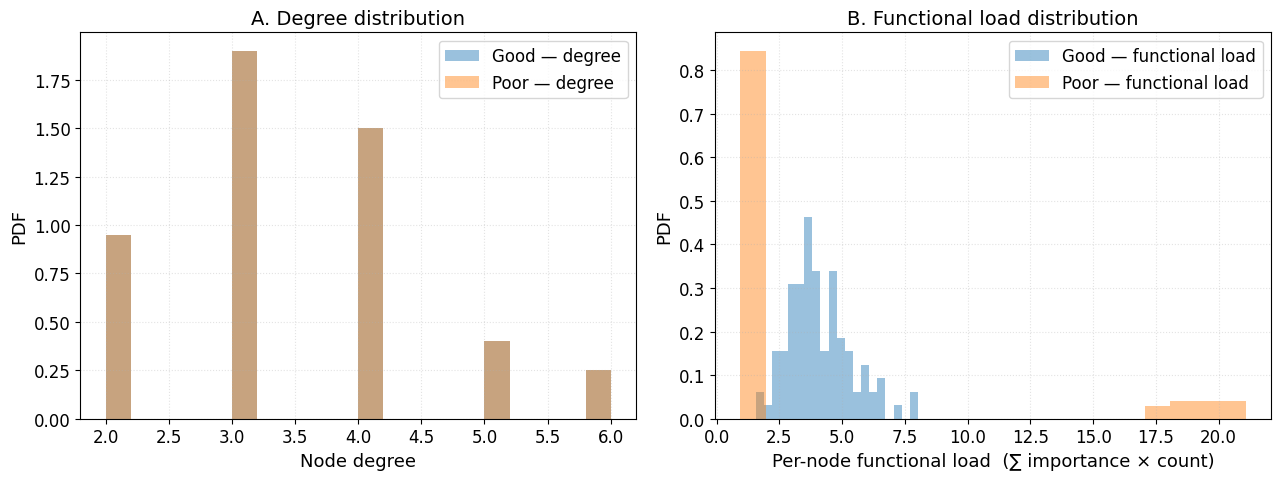

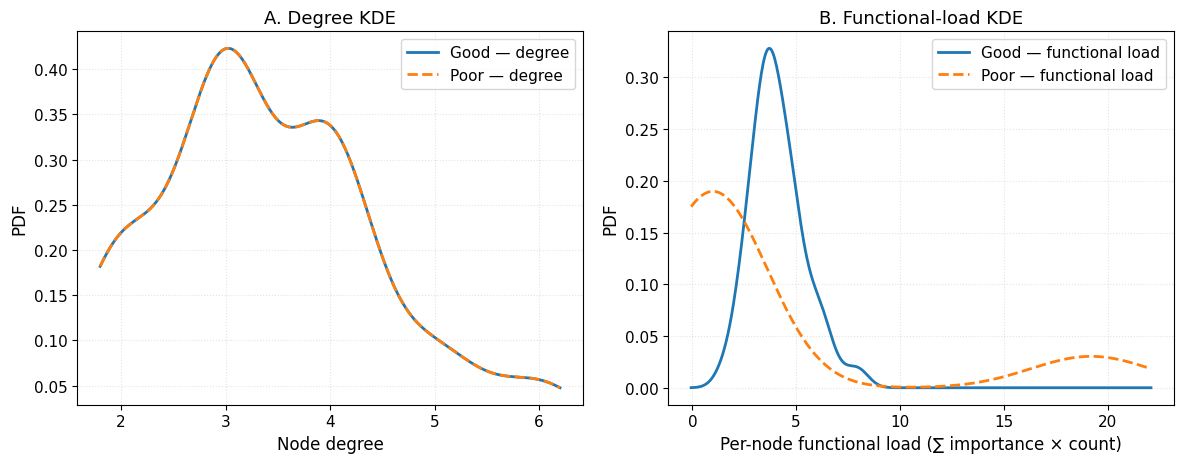

Saving G1 datasets...
G1: 100 nodes, 171 edges

Generating G2 (India Network)...
Comparing good vs poor function placement

2. Generating GOOD function placement...
   Good placement: 744 total placements
   Functions deployed: 17
   Nodes with functions: 142

3. Generating POOR function placement (centralized strategy)...
   Poor placement: 691 total placements
   Functions deployed: 17
   Nodes with functions: 142

Functional Distribution — Network summaries
Good: {'FDS_entropy': 0.9892006966135704, 'HHI_norm': 0.0007408944772342158, 'Gini': 0.18035978769615646}
Poor: {'FDS_entropy': 0.80724801529023, 'HHI_norm': 0.021029779783731935, 'Gini': 0.6328778175624077}


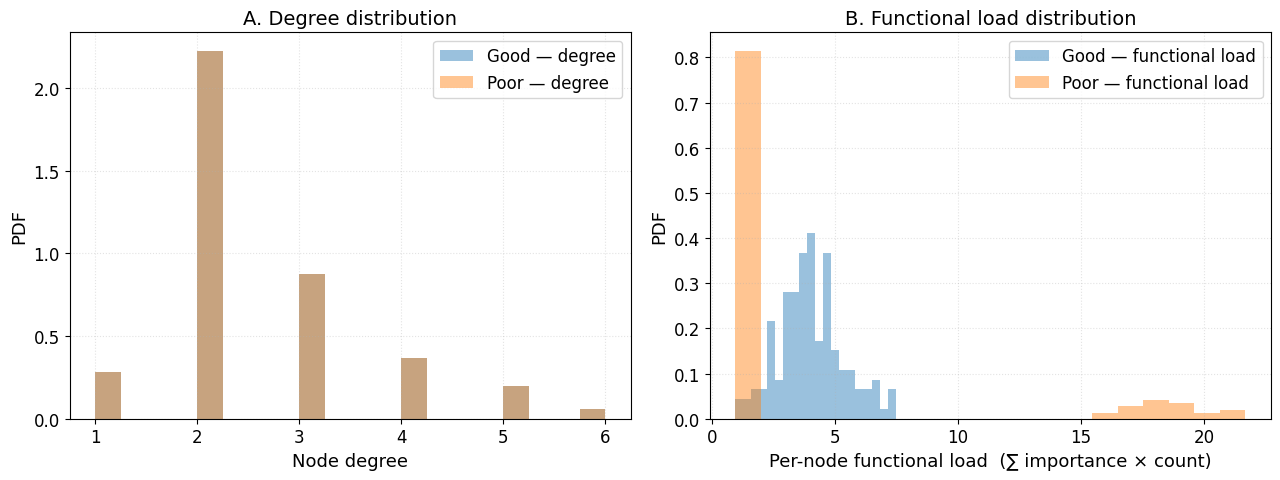

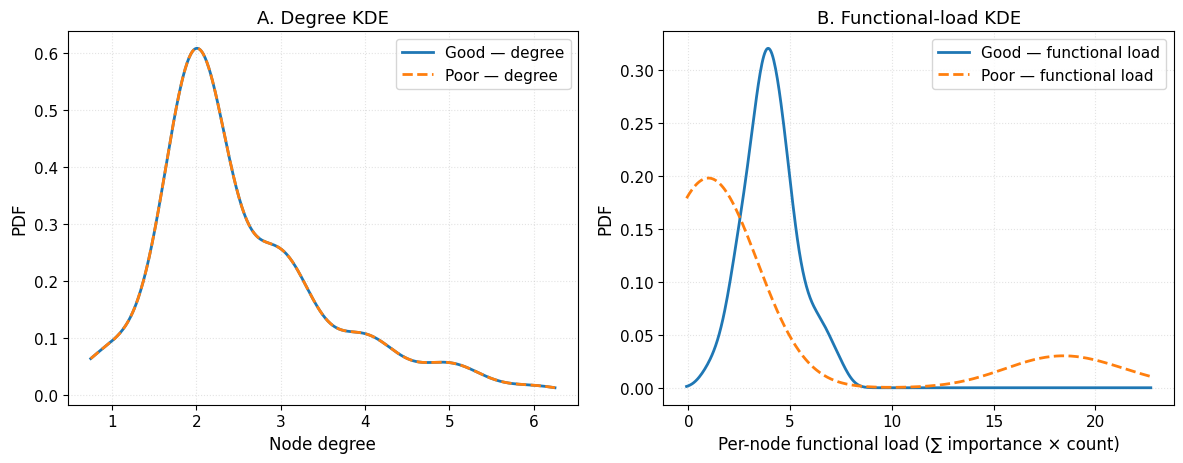

Saving G2 datasets...
G2: 142 nodes, 180 edges

Generating G3 (UK Network)...
Comparing good vs poor function placement

2. Generating GOOD function placement...
   Good placement: 558 total placements
   Functions deployed: 17
   Nodes with functions: 106

3. Generating POOR function placement (centralized strategy)...
   Poor placement: 510 total placements
   Functions deployed: 17
   Nodes with functions: 106

Functional Distribution — Network summaries
Good: {'FDS_entropy': 0.9864847787328374, 'HHI_norm': 0.0011854563848957157, 'Gini': 0.1979024170785575}
Poor: {'FDS_entropy': 0.7882994028018174, 'HHI_norm': 0.029594884267138594, 'Gini': 0.6347278040333337}


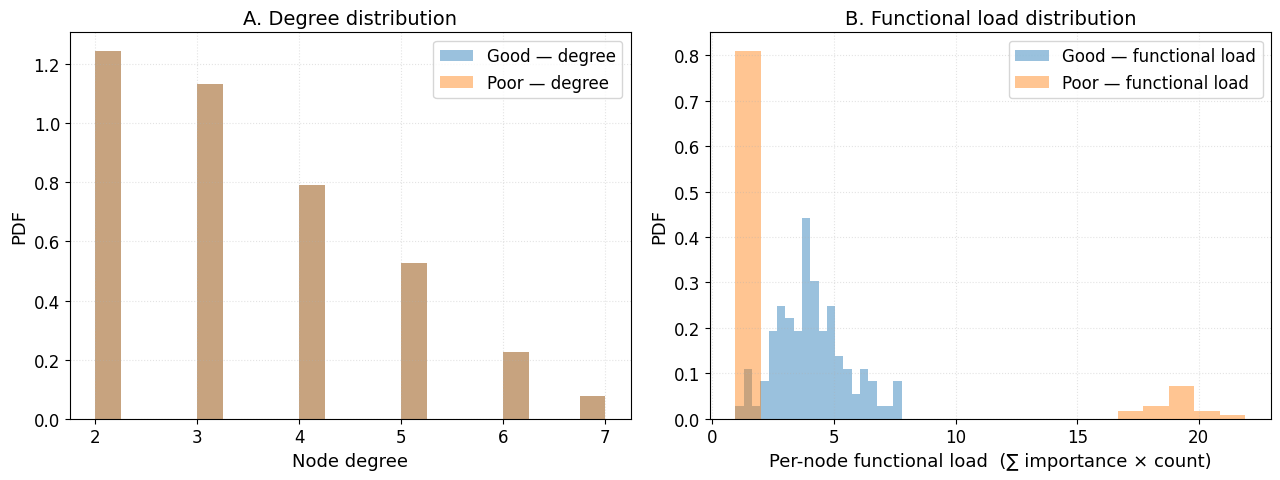

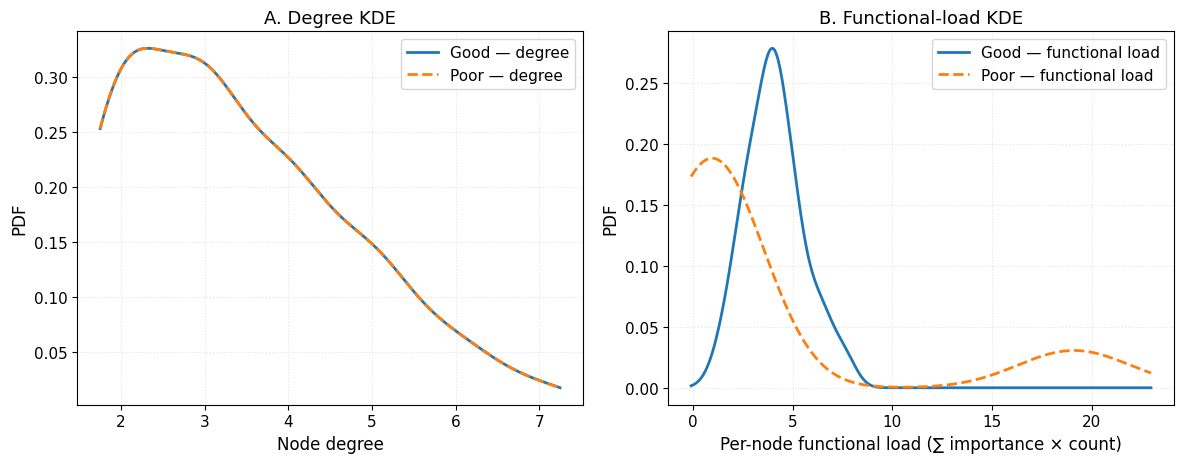

Saving G3 datasets...
G3: 106 nodes, 180 edges

✓ All datasets saved to 'datasets/' directory


In [4]:
# =============================================================================
# DATA CURATION: Generate and Save Datasets for G1, G2, G3
# =============================================================================

# Create output directory for datasets
os.makedirs('datasets', exist_ok=True)

# -----------------------------------------------------------------------------
# G1: USA Network (usa100)
# -----------------------------------------------------------------------------
print("Generating G1 (USA Network)...")
G1 = create_usa100_graph()
good_data_g1, poor_data_g1 = create_functional_attributed_graph_data(G1)

# Save G1 datasets
print("Saving G1 datasets...")
good_data_g1['nodes'].to_csv('datasets/G1_USA_nodes_distributed.csv', index=False)
good_data_g1['edges'].to_csv('datasets/G1_USA_edges_distributed.csv', index=False)
good_data_g1['functions'].to_csv('datasets/G1_USA_functions_distributed.csv', index=False)
good_data_g1['function_placement'].to_csv('datasets/G1_USA_function_placement_distributed.csv', index=False)

poor_data_g1['nodes'].to_csv('datasets/G1_USA_nodes_centralized.csv', index=False)
poor_data_g1['edges'].to_csv('datasets/G1_USA_edges_centralized.csv', index=False)
poor_data_g1['functions'].to_csv('datasets/G1_USA_functions_centralized.csv', index=False)
poor_data_g1['function_placement'].to_csv('datasets/G1_USA_function_placement_centralized.csv', index=False)

print(f"G1: {G1.number_of_nodes()} nodes, {G1.number_of_edges()} edges")

# -----------------------------------------------------------------------------
# G2: India Network (TataNLD)
# -----------------------------------------------------------------------------
print("\nGenerating G2 (India Network)...")
G2 = create_tatanid_graph()
good_data_g2, poor_data_g2 = create_functional_attributed_graph_data(G2)

# Save G2 datasets
print("Saving G2 datasets...")
good_data_g2['nodes'].to_csv('datasets/G2_India_nodes_distributed.csv', index=False)
good_data_g2['edges'].to_csv('datasets/G2_India_edges_distributed.csv', index=False)
good_data_g2['functions'].to_csv('datasets/G2_India_functions_distributed.csv', index=False)
good_data_g2['function_placement'].to_csv('datasets/G2_India_function_placement_distributed.csv', index=False)

poor_data_g2['nodes'].to_csv('datasets/G2_India_nodes_centralized.csv', index=False)
poor_data_g2['edges'].to_csv('datasets/G2_India_edges_centralized.csv', index=False)
poor_data_g2['functions'].to_csv('datasets/G2_India_functions_centralized.csv', index=False)
poor_data_g2['function_placement'].to_csv('datasets/G2_India_function_placement_centralized.csv', index=False)

print(f"G2: {G2.number_of_nodes()} nodes, {G2.number_of_edges()} edges")

# -----------------------------------------------------------------------------
# G3: UK Network (BT_106)
# -----------------------------------------------------------------------------
print("\nGenerating G3 (UK Network)...")
G3 = create_BT_106_graph()
good_data_g3, poor_data_g3 = create_functional_attributed_graph_data(G3)

# Save G3 datasets
print("Saving G3 datasets...")
good_data_g3['nodes'].to_csv('datasets/G3_UK_nodes_distributed.csv', index=False)
good_data_g3['edges'].to_csv('datasets/G3_UK_edges_distributed.csv', index=False)
good_data_g3['functions'].to_csv('datasets/G3_UK_functions_distributed.csv', index=False)
good_data_g3['function_placement'].to_csv('datasets/G3_UK_function_placement_distributed.csv', index=False)

poor_data_g3['nodes'].to_csv('datasets/G3_UK_nodes_centralized.csv', index=False)
poor_data_g3['edges'].to_csv('datasets/G3_UK_edges_centralized.csv', index=False)
poor_data_g3['functions'].to_csv('datasets/G3_UK_functions_centralized.csv', index=False)
poor_data_g3['function_placement'].to_csv('datasets/G3_UK_function_placement_centralized.csv', index=False)

print(f"G3: {G3.number_of_nodes()} nodes, {G3.number_of_edges()} edges")

print("\n✓ All datasets saved to 'datasets/' directory")
print("=" * 80)



## 4. Monte Carlo Attack-Recovery Simulation

**Attack Phase**: Probabilistic node removal (α=1.5)  
**Recovery Phase**: Deterministic highest-degree node restoration

Computes:
- Service Continuity & Coverage for distributed and centralized placements
- Algebraic Connectivity (topology-only baseline)


Running Attack-Recovery Analysis for FIRE Framework
Creating topologies...

Processing US...
Comparing good vs poor function placement

2. Generating GOOD function placement...
   Good placement: 533 total placements
   Functions deployed: 17
   Nodes with functions: 100

3. Generating POOR function placement (centralized strategy)...
   Poor placement: 487 total placements
   Functions deployed: 17
   Nodes with functions: 100

Functional Distribution — Network summaries
Good: {'FDS_entropy': 0.9897171847975084, 'HHI_norm': 0.000983042253747872, 'Gini': 0.1717564015188393}
Poor: {'FDS_entropy': 0.7891099701716082, 'HHI_norm': 0.030884320103904298, 'Gini': 0.6349322580645158}


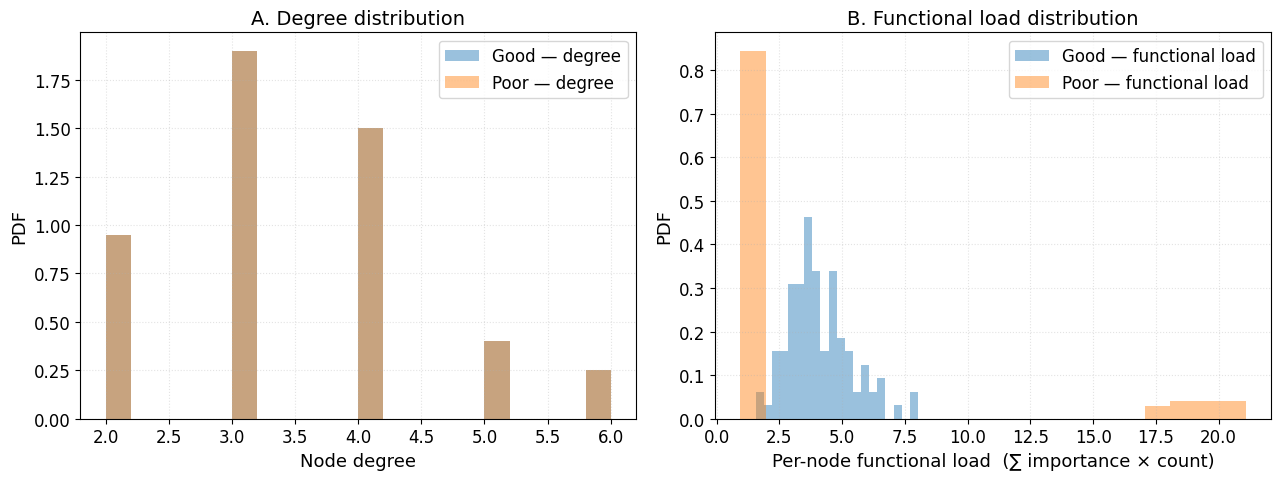

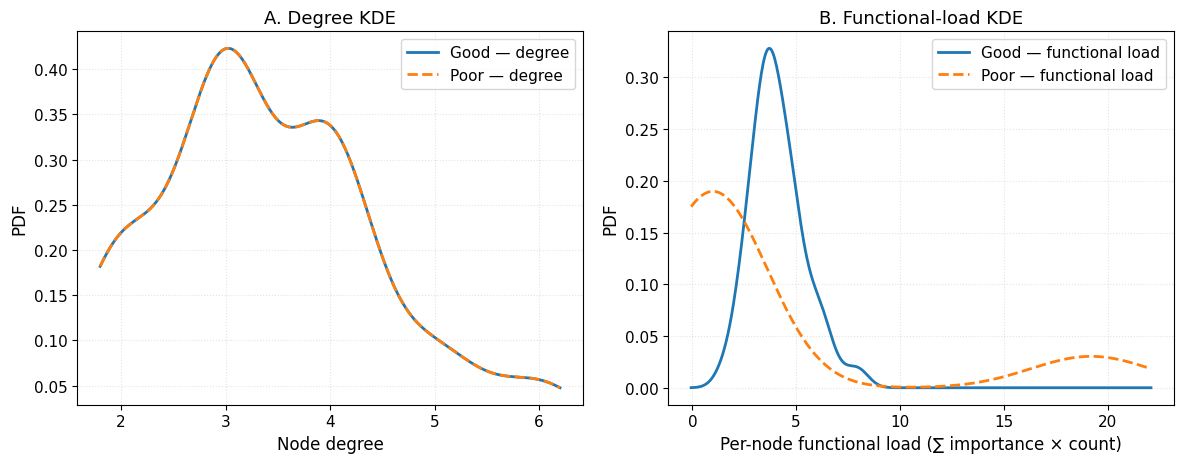

Poor placement: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]



Processing India...
Comparing good vs poor function placement

2. Generating GOOD function placement...
   Good placement: 744 total placements
   Functions deployed: 17
   Nodes with functions: 142

3. Generating POOR function placement (centralized strategy)...
   Poor placement: 691 total placements
   Functions deployed: 17
   Nodes with functions: 142

Functional Distribution — Network summaries
Good: {'FDS_entropy': 0.9892006966135704, 'HHI_norm': 0.0007408944772342158, 'Gini': 0.18035978769615646}
Poor: {'FDS_entropy': 0.80724801529023, 'HHI_norm': 0.021029779783731935, 'Gini': 0.6328778175624077}


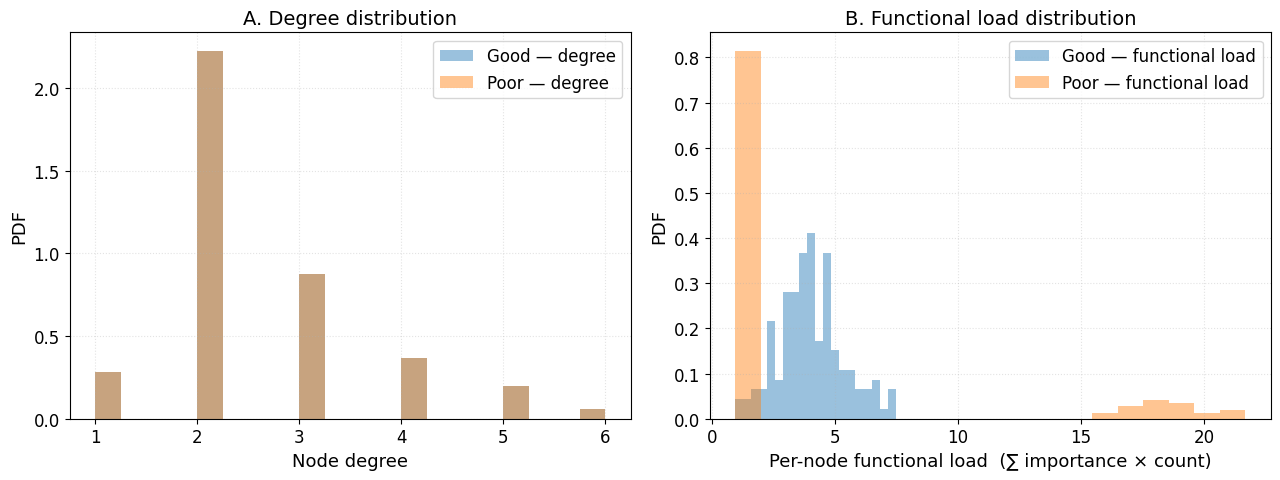

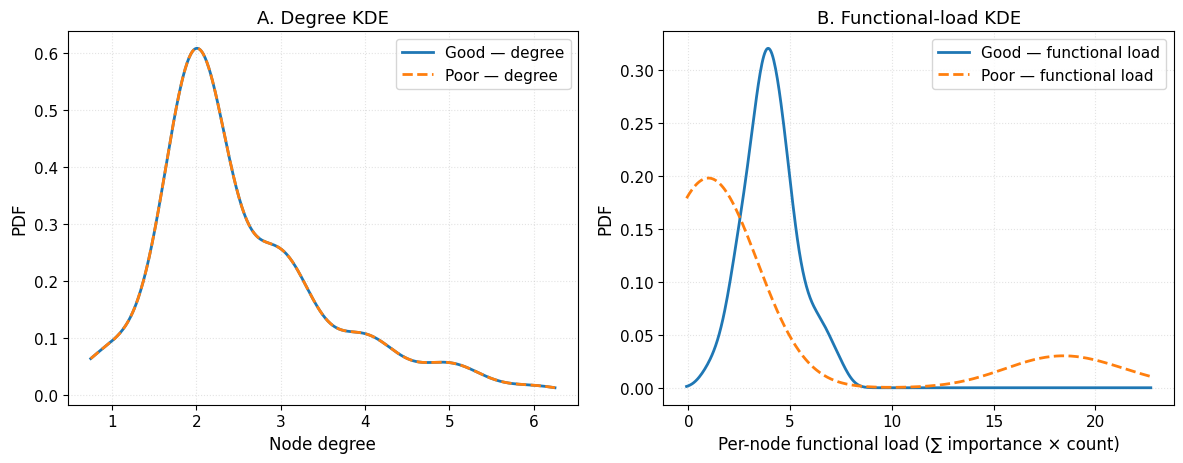

Poor placement: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]



Processing UK...
Comparing good vs poor function placement

2. Generating GOOD function placement...
   Good placement: 558 total placements
   Functions deployed: 17
   Nodes with functions: 106

3. Generating POOR function placement (centralized strategy)...
   Poor placement: 510 total placements
   Functions deployed: 17
   Nodes with functions: 106

Functional Distribution — Network summaries
Good: {'FDS_entropy': 0.9864847787328374, 'HHI_norm': 0.0011854563848957157, 'Gini': 0.1979024170785575}
Poor: {'FDS_entropy': 0.7882994028018174, 'HHI_norm': 0.029594884267138594, 'Gini': 0.6347278040333337}


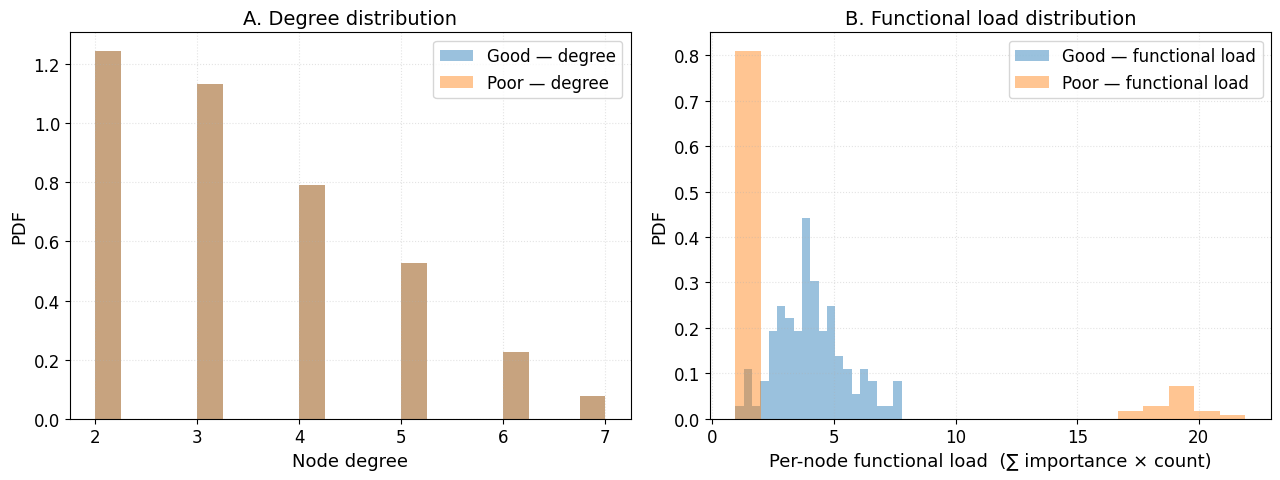

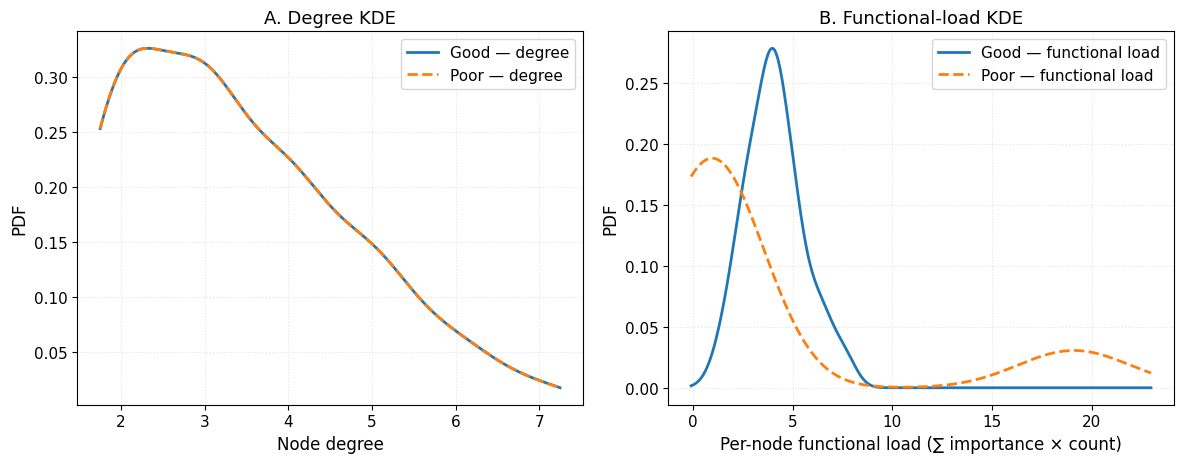

Poor placement: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]



Generating publication figure...


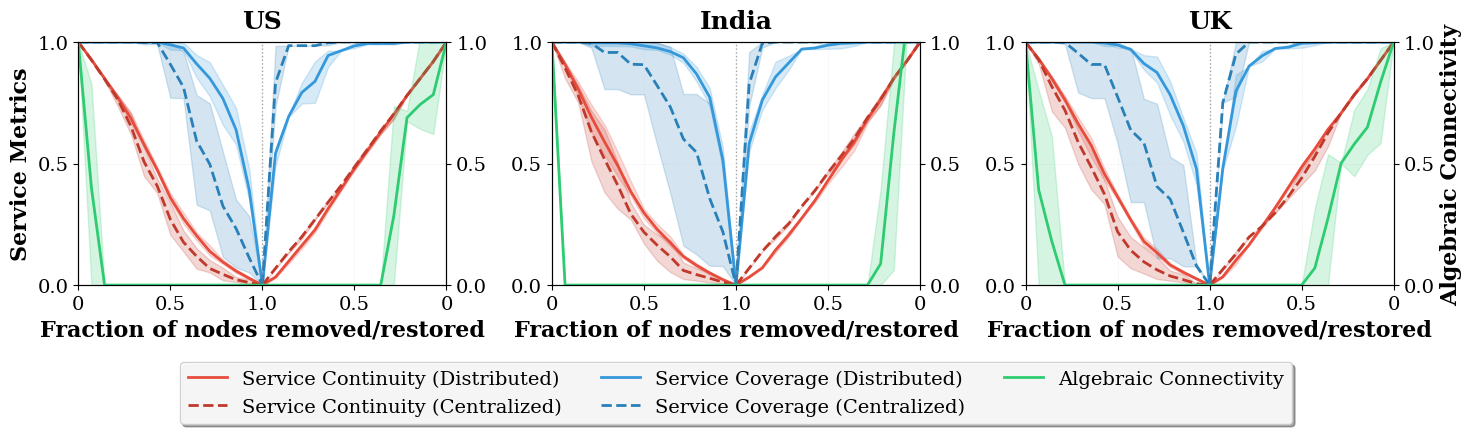

In [5]:
# Attack-Recovery Analysis for FIRE Framework
# Publication Figure: Attack and Recovery Phases across US, India, UK Topologies

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Set
from tqdm import tqdm

def run_attack_recovery_simulation(
    G0: nx.Graph,
    good_data: Dict[str, pd.DataFrame],
    poor_data: Dict[str, pd.DataFrame],
    alpha: float = 1.5,
    n_runs: int = 50,
    n_steps: int = 15,
    seed: int = 42
) -> Dict:
    """
    Run attack-recovery simulation for both good and poor placements.

    Attack phase: Probabilistic node removal (α=1.5)
    Recovery phase: Deterministic highest-degree node recovery

    Returns metrics for Service Continuity, Service Coverage, and Algebraic Connectivity
    """
    fractions = np.linspace(0, 1, n_steps)

    # Initialize result storage
    results = {
        'fractions': fractions,
        'attack_fractions': fractions,
        'recovery_fractions': fractions[::-1],  # Recovery goes from 1.0 back to 0
        'good': {
            'service_continuity_attack': np.zeros((n_runs, n_steps)),
            'service_coverage_attack': np.zeros((n_runs, n_steps)),
            'algebraic_connectivity_attack': np.zeros((n_runs, n_steps)),
            'service_continuity_recovery': np.zeros((n_runs, n_steps)),
            'service_coverage_recovery': np.zeros((n_runs, n_steps)),
            'algebraic_connectivity_recovery': np.zeros((n_runs, n_steps)),
        },
        'poor': {
            'service_continuity_attack': np.zeros((n_runs, n_steps)),
            'service_coverage_attack': np.zeros((n_runs, n_steps)),
            'algebraic_connectivity_attack': np.zeros((n_runs, n_steps)),
            'service_continuity_recovery': np.zeros((n_runs, n_steps)),
            'service_coverage_recovery': np.zeros((n_runs, n_steps)),
            'algebraic_connectivity_recovery': np.zeros((n_runs, n_steps)),
        }
    }

    # Compute baselines
    baseline_ac = nx.algebraic_connectivity(G0) if G0.number_of_nodes() >= 2 else 0.0

    for placement_type, data in [('good', good_data), ('poor', poor_data)]:
        functions_df = data['functions']
        placement_df = data['function_placement']
        nodes_df = data['nodes']

        # Compute function baselines
        baselines = {}
        for _, row in functions_df.iterrows():
            func = row['function']
            baselines[func] = compute_function_baseline(G0, func, placement_df, nodes_df)

        for run in tqdm(range(n_runs), desc=f"{placement_type.title()} placement"):
            run_seed = seed + run

            # Sample failure order for attack phase (probabilistic)
            failure_order = sample_node_failure_order(G0, alpha, seed=run_seed)
            total_nodes = len(list(G0.nodes()))

            # ATTACK PHASE: Progressive node removal
            G_attack = G0.copy()
            for step_idx, frac in enumerate(fractions):
                n_remove = int(frac * total_nodes)

                if step_idx > 0:
                    n_prev = int(fractions[step_idx - 1] * total_nodes)
                    new_removals = failure_order[n_prev:n_remove]
                    new_removals = [n for n in new_removals if n in G_attack.nodes()]
                    G_attack.remove_nodes_from(new_removals)

                # Compute metrics
                if G_attack.number_of_nodes() > 0:
                    fire = compute_network_fire_metrics(G_attack, G0, functions_df, placement_df, nodes_df, baselines)
                    results[placement_type]['service_continuity_attack'][run, step_idx] = fire['service_continuity']
                    results[placement_type]['service_coverage_attack'][run, step_idx] = fire['service_coverage']

                    current_ac = nx.algebraic_connectivity(G_attack) if G_attack.number_of_nodes() >= 2 else 0.0
                    results[placement_type]['algebraic_connectivity_attack'][run, step_idx] = current_ac / baseline_ac if baseline_ac > 0 else 0.0
                else:
                    results[placement_type]['service_continuity_attack'][run, step_idx] = 0.0
                    results[placement_type]['service_coverage_attack'][run, step_idx] = 0.0
                    results[placement_type]['algebraic_connectivity_attack'][run, step_idx] = 0.0

            # RECOVERY PHASE: Deterministic highest-degree node recovery using high alpha
            # Start from the most damaged state and add back nodes using probabilistic model
            # with very high alpha (α=100) to make it effectively deterministic
            remaining_nodes = list(G_attack.nodes())
            removed_nodes = [n for n in G0.nodes() if n not in remaining_nodes]

            if removed_nodes:
                # Create subgraph of removed nodes to use sampling function
                G_removed = G0.subgraph(removed_nodes).copy()
                # Use very high alpha for deterministic targeting of high-degree nodes
                recovery_order = sample_node_failure_order(G_removed, alpha=100.0, seed=run_seed+1000)
                removed_by_degree = recovery_order
            else:
                removed_by_degree = []

            G_recovery = G_attack.copy()
            recovery_steps = len(fractions)
            nodes_to_add_per_step = len(removed_by_degree) / (recovery_steps - 1) if recovery_steps > 1 else 0

            for step_idx in range(recovery_steps):
                if step_idx == 0:
                    # First step is the most damaged state (same as last attack step)
                    results[placement_type]['service_continuity_recovery'][run, step_idx] = results[placement_type]['service_continuity_attack'][run, -1]
                    results[placement_type]['service_coverage_recovery'][run, step_idx] = results[placement_type]['service_coverage_attack'][run, -1]
                    results[placement_type]['algebraic_connectivity_recovery'][run, step_idx] = results[placement_type]['algebraic_connectivity_attack'][run, -1]
                else:
                    # Add back nodes deterministically
                    nodes_to_add = int(step_idx * nodes_to_add_per_step)
                    nodes_to_restore = removed_by_degree[:nodes_to_add]

                    # Add nodes and their edges
                    G_recovery.add_nodes_from(nodes_to_restore)
                    for n in nodes_to_restore:
                        for neighbor in G0.neighbors(n):
                            if neighbor in G_recovery.nodes():
                                G_recovery.add_edge(n, neighbor, **G0[n][neighbor])

                    # Compute metrics
                    if G_recovery.number_of_nodes() > 0:
                        fire = compute_network_fire_metrics(G_recovery, G0, functions_df, placement_df, nodes_df, baselines)
                        results[placement_type]['service_continuity_recovery'][run, step_idx] = fire['service_continuity']
                        results[placement_type]['service_coverage_recovery'][run, step_idx] = fire['service_coverage']

                        current_ac = nx.algebraic_connectivity(G_recovery) if G_recovery.number_of_nodes() >= 2 else 0.0
                        results[placement_type]['algebraic_connectivity_recovery'][run, step_idx] = current_ac / baseline_ac if baseline_ac > 0 else 0.0
                    else:
                        results[placement_type]['service_continuity_recovery'][run, step_idx] = 0.0
                        results[placement_type]['service_coverage_recovery'][run, step_idx] = 0.0
                        results[placement_type]['algebraic_connectivity_recovery'][run, step_idx] = 0.0

    return results


def plot_attack_recovery_publication_figure(
    results_us: Dict,
    results_india: Dict,
    results_uk: Dict
):
    """
    Create publication-ready figure with attack-recovery phases for three topologies.
    """
    # Set up publication style with larger fonts for readability
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'figure.titlesize': 20,
        'font.family': 'serif'
        # ,
        # 'font.serif': ['Times New Roman', 'Times', 'serif']
    })

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    topologies = [
        ('US', results_us),
        ('India', results_india),
        ('UK', results_uk)
    ]

    # Colors consistent with FIRE framework
    colors = {
        'service_continuity_good': '#e74c3c',     # Service Continuity - Good
        'service_continuity_poor': '#c0392b',     # Service Continuity - Poor
        'service_coverage_good': '#3498db',     # Service Coverage - Good
        'service_coverage_poor': '#2980b9',     # Service Coverage - Poor
        'algebraic_connectivity': '#2ecc71'          # Algebraic Connectivity
    }

    for idx, (topology_name, results) in enumerate(topologies):
        ax = axes[idx]
        ax2 = ax.twinx()  # Second y-axis for Algebraic Connectivity

        n_steps = len(results['fractions'])

        # Create continuous x-axis: attack (0 to 1) + recovery (1 to 2)
        x_attack = results['fractions']  # 0 to 1
        x_recovery = 1 + results['fractions']  # 1 to 2
        x_full = np.concatenate([x_attack, x_recovery])

        # === ATTACK PHASE ===
        # Service Continuity (A) - Good placement
        A_good_attack = results['good']['service_continuity_attack']
        A_good_mean = np.mean(A_good_attack, axis=0)
        A_good_ci = np.percentile(A_good_attack, [2.5, 97.5], axis=0)

        ax.plot(x_attack, A_good_mean, color=colors['service_continuity_good'], linewidth=2,
                label='Service Continuity (Distributed)', linestyle='-')
        ax.fill_between(x_attack, A_good_ci[0], A_good_ci[1],
                       color=colors['service_continuity_good'], alpha=0.2)

        # Service Continuity (A) - Poor placement
        A_poor_attack = results['poor']['service_continuity_attack']
        A_poor_mean = np.mean(A_poor_attack, axis=0)
        A_poor_ci = np.percentile(A_poor_attack, [2.5, 97.5], axis=0)

        ax.plot(x_attack, A_poor_mean, color=colors['service_continuity_poor'], linewidth=2,
                label='Service Continuity (Centralized)', linestyle='--')
        ax.fill_between(x_attack, A_poor_ci[0], A_poor_ci[1],
                       color=colors['service_continuity_poor'], alpha=0.2)

        # Service Coverage (C) - Good placement
        C_good_attack = results['good']['service_coverage_attack']
        C_good_mean = np.mean(C_good_attack, axis=0)
        C_good_ci = np.percentile(C_good_attack, [2.5, 97.5], axis=0)

        ax.plot(x_attack, C_good_mean, color=colors['service_coverage_good'], linewidth=2,
                label='Service Coverage (Distributed)', linestyle='-')
        ax.fill_between(x_attack, C_good_ci[0], C_good_ci[1],
                       color=colors['service_coverage_good'], alpha=0.2)

        # Service Coverage (C) - Poor placement
        C_poor_attack = results['poor']['service_coverage_attack']
        C_poor_mean = np.mean(C_poor_attack, axis=0)
        C_poor_ci = np.percentile(C_poor_attack, [2.5, 97.5], axis=0)

        ax.plot(x_attack, C_poor_mean, color=colors['service_coverage_poor'], linewidth=2,
                label='Service Coverage (Centralized)', linestyle='--')
        ax.fill_between(x_attack, C_poor_ci[0], C_poor_ci[1],
                       color=colors['service_coverage_poor'], alpha=0.2)

        # Algebraic Connectivity (same for both placements)
        AC_attack = results['good']['algebraic_connectivity_attack']  # Same for both placements
        AC_mean = np.mean(AC_attack, axis=0)
        AC_ci = np.percentile(AC_attack, [2.5, 97.5], axis=0)

        ax2.plot(x_attack, AC_mean, color=colors['algebraic_connectivity'], linewidth=2,
                 label='Algebraic Connectivity', linestyle='-')
        ax2.fill_between(x_attack, AC_ci[0], AC_ci[1],
                        color=colors['algebraic_connectivity'], alpha=0.2)

        # === RECOVERY PHASE ===
        # Service Continuity (A) - Good placement
        A_good_recovery = results['good']['service_continuity_recovery']
        A_good_mean_rec = np.mean(A_good_recovery, axis=0)
        A_good_ci_rec = np.percentile(A_good_recovery, [2.5, 97.5], axis=0)

        ax.plot(x_recovery, A_good_mean_rec, color=colors['service_continuity_good'], linewidth=2, linestyle='-')
        ax.fill_between(x_recovery, A_good_ci_rec[0], A_good_ci_rec[1],
                       color=colors['service_continuity_good'], alpha=0.2)

        # Service Continuity (A) - Poor placement
        A_poor_recovery = results['poor']['service_continuity_recovery']
        A_poor_mean_rec = np.mean(A_poor_recovery, axis=0)
        A_poor_ci_rec = np.percentile(A_poor_recovery, [2.5, 97.5], axis=0)

        ax.plot(x_recovery, A_poor_mean_rec, color=colors['service_continuity_poor'], linewidth=2, linestyle='--')
        ax.fill_between(x_recovery, A_poor_ci_rec[0], A_poor_ci_rec[1],
                       color=colors['service_continuity_poor'], alpha=0.2)

        # Service Coverage (C) - Good placement
        C_good_recovery = results['good']['service_coverage_recovery']
        C_good_mean_rec = np.mean(C_good_recovery, axis=0)
        C_good_ci_rec = np.percentile(C_good_recovery, [2.5, 97.5], axis=0)

        ax.plot(x_recovery, C_good_mean_rec, color=colors['service_coverage_good'], linewidth=2, linestyle='-')
        ax.fill_between(x_recovery, C_good_ci_rec[0], C_good_ci_rec[1],
                       color=colors['service_coverage_good'], alpha=0.2)

        # Service Coverage (C) - Poor placement
        C_poor_recovery = results['poor']['service_coverage_recovery']
        C_poor_mean_rec = np.mean(C_poor_recovery, axis=0)
        C_poor_ci_rec = np.percentile(C_poor_recovery, [2.5, 97.5], axis=0)

        ax.plot(x_recovery, C_poor_mean_rec, color=colors['service_coverage_poor'], linewidth=2, linestyle='--')
        ax.fill_between(x_recovery, C_poor_ci_rec[0], C_poor_ci_rec[1],
                       color=colors['service_coverage_poor'], alpha=0.2)

        # Algebraic Connectivity - Recovery
        AC_recovery = results['good']['algebraic_connectivity_recovery']
        AC_mean_rec = np.mean(AC_recovery, axis=0)
        AC_ci_rec = np.percentile(AC_recovery, [2.5, 97.5], axis=0)

        ax2.plot(x_recovery, AC_mean_rec, color=colors['algebraic_connectivity'], linewidth=2, linestyle='-')
        ax2.fill_between(x_recovery, AC_ci_rec[0], AC_ci_rec[1],
                        color=colors['algebraic_connectivity'], alpha=0.2)

        # Formatting
        ax.set_xlim([0, 2])
        ax.set_ylim([0, 1])
        ax2.set_ylim([0, 1])

        # Add vertical line to separate attack and recovery phases
        ax.axvline(x=1, color='gray', linestyle=':', alpha=0.7, linewidth=1)

        # Labels and titles
        if idx == 0:
            ax.set_ylabel('Service Metrics', fontweight='bold')
        if idx == 2:
            ax2.set_ylabel('Algebraic Connectivity', fontweight='bold')

        ax.set_xlabel('Fraction of nodes removed/restored', fontweight='bold')
        ax.set_title(topology_name, fontweight='bold', pad=10)

        # Custom x-axis labels with clearer notation
        ax.set_xticks([0, 0.5, 1, 1.5, 2])
        ax.set_xticklabels(['0', '0.5', '1.0', '0.5', '0'])

        # Y-axis ticks
        ax.set_yticks([0, 0.5, 1])
        ax2.set_yticks([0, 0.5, 1])

        # Grid
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # Increased bottom margin for phase labels

    # Create legend outside the plot area using the actual legend elements from axes
    # Collect legend elements manually to ensure Algebraic Connectivity is included
    legend_elements = [
        plt.Line2D([0], [0], color=colors['service_continuity_good'], linewidth=2, linestyle='-',
                   label='Service Continuity (Distributed)'),
        plt.Line2D([0], [0], color=colors['service_continuity_poor'], linewidth=2, linestyle='--',
                   label='Service Continuity (Centralized)'),
        plt.Line2D([0], [0], color=colors['service_coverage_good'], linewidth=2, linestyle='-',
                   label='Service Coverage (Distributed)'),
        plt.Line2D([0], [0], color=colors['service_coverage_poor'], linewidth=2, linestyle='--',
                   label='Service Coverage (Centralized)'),
        plt.Line2D([0], [0], color=colors['algebraic_connectivity'], linewidth=2, linestyle='-',
                   label='Algebraic Connectivity')
    ]

    # Place legend outside plot area
    fig.legend(handles=legend_elements,
              loc='center', bbox_to_anchor=(0.5, -0.02),
              ncol=3, frameon=True, fontsize=14,
              framealpha=0.9, fancybox=True, shadow=True)

    # # Add phase labels below x-axis with better positioning to avoid overlap
    # fig.text(0.25, 0.08, 'Attack Phase', ha='center', fontweight='bold', fontsize=16)
    # fig.text(0.75, 0.08, 'Recovery Phase', ha='center', fontweight='bold', fontsize=16)

    plt.show()


# Example usage with your existing data structure
def run_complete_attack_recovery_analysis():
    """
    Run the complete attack-recovery analysis for all three topologies
    """
    print("Running Attack-Recovery Analysis for FIRE Framework")
    print("=" * 60)

    # Create topologies
    print("Creating topologies...")
    G_us = create_usa100_graph()
    G_india = create_tatanid_graph()
    G_uk = create_BT_106_graph()

    topologies = [
        ("US", G_us),
        ("India", G_india),
        ("UK", G_uk)
    ]

    all_results = {}

    for name, G in topologies:
        print(f"\nProcessing {name}...")

        # Generate good and poor placement data
        good_data, poor_data = create_functional_attributed_graph_data(G)

        # Run attack-recovery simulation
        results = run_attack_recovery_simulation(
            G, good_data, poor_data,
            alpha=1.5, n_runs=5, n_steps=15, seed=42 # Update to 50 in the final run 😊
        )

        all_results[name.split()[0].lower()] = results

    # Create publication figure
    print("\nGenerating publication figure...")
    plot_attack_recovery_publication_figure(
        all_results['us'],
        all_results['india'],
        all_results['uk']
    )

    return all_results

# Uncomment to run:
results = run_complete_attack_recovery_analysis()


## 5. Visualization: Placement Strategy Comparison

Three-panel comparison showing:
- (a) Placement Independent (Algebraic Connectivity only)
- (b) Centralized Placement (Functional metrics degrade)
- (c) Distributed Placement (Functional metrics preserved)


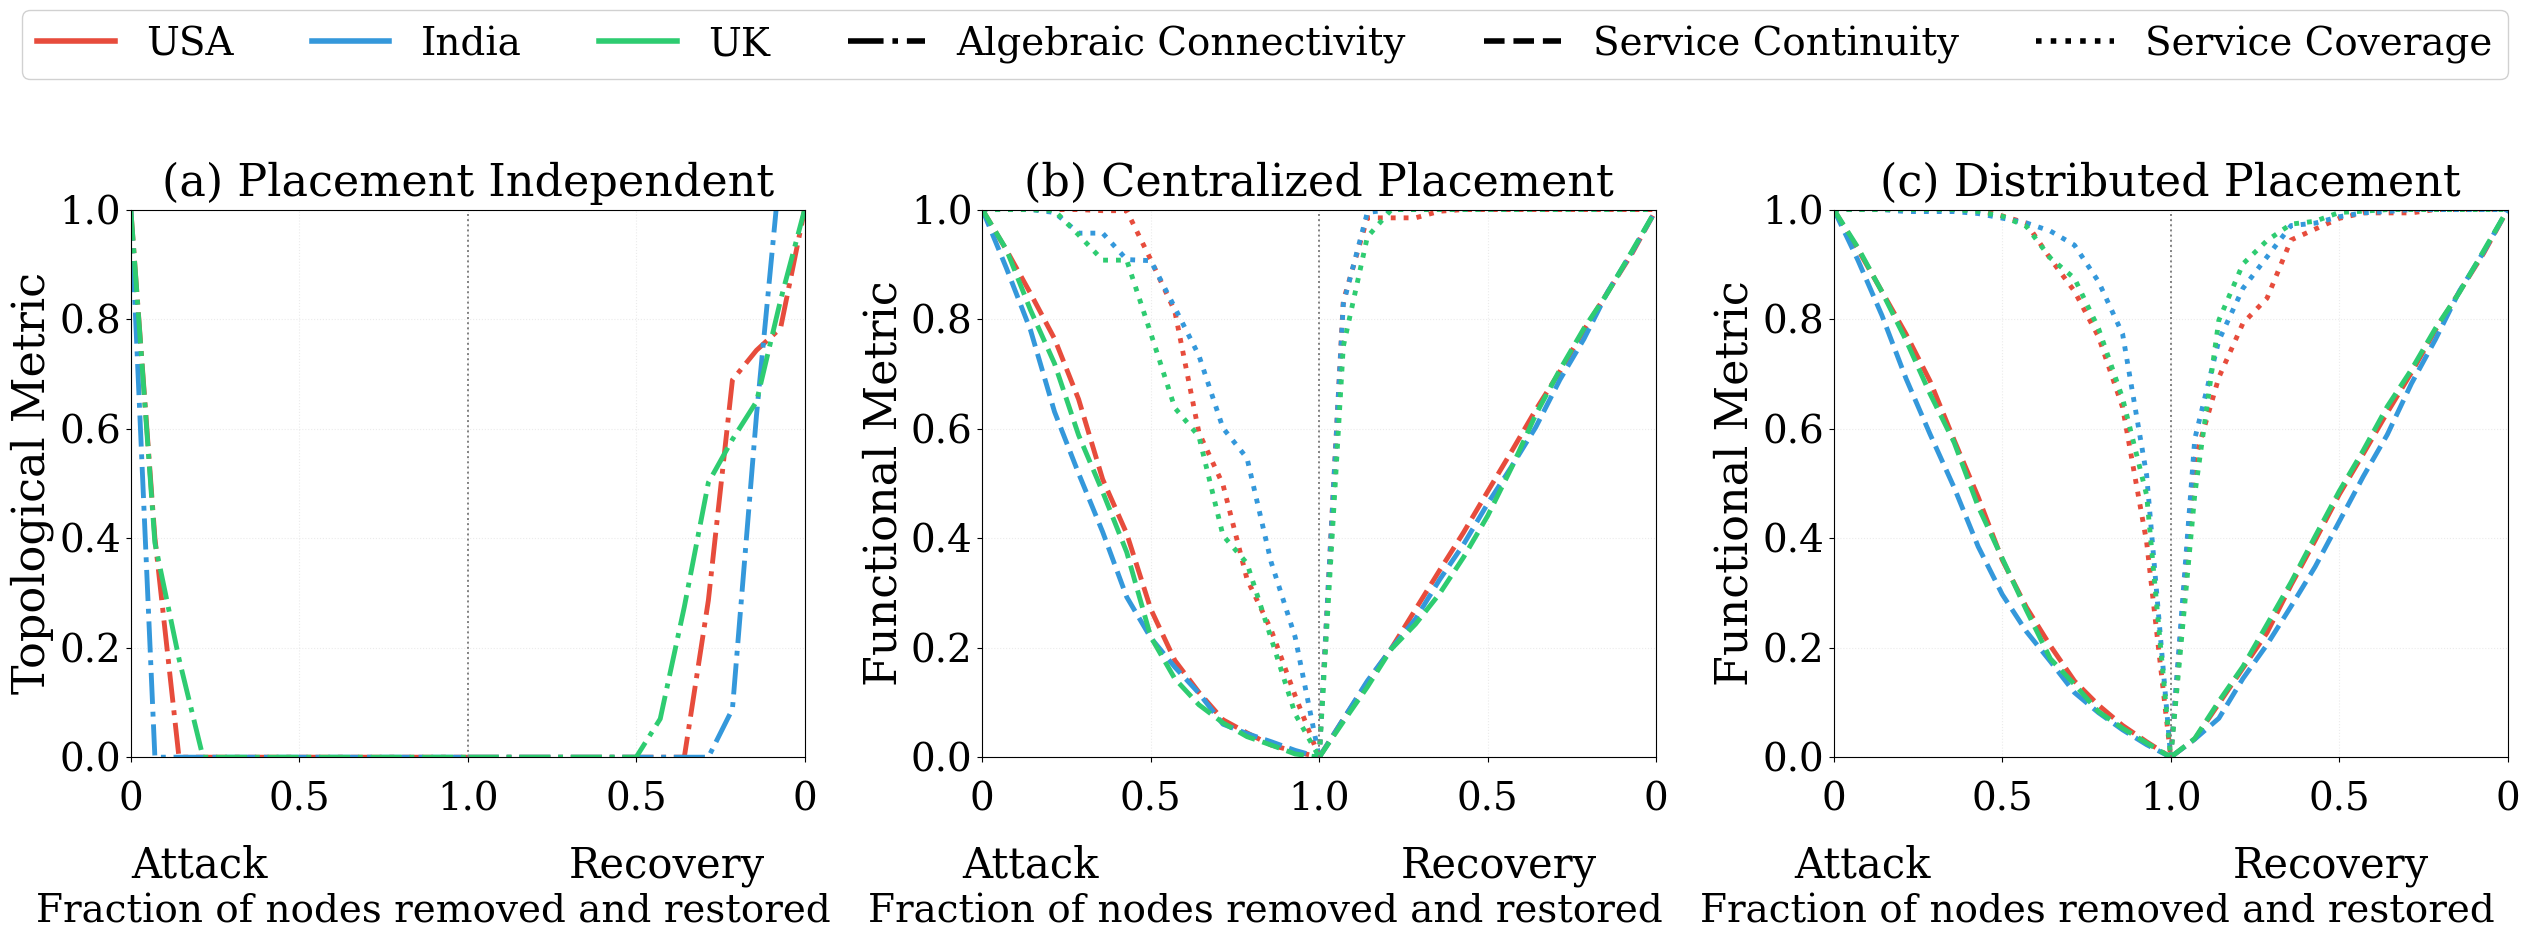

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def plot_attack_recovery_final_camera(all_results):
    """
    Final OFC-ready camera version:
    - No bold headings or axes
    - Titles same font size as y-axis
    - Larger bottom and legend text
    """

    plt.rcParams.update({
        'font.size': 30,
        'axes.titlesize': 32,      # same as y-axis
        'axes.labelsize': 32,
        'xtick.labelsize': 28,
        'ytick.labelsize': 28,
        'legend.fontsize': 28,     # same as caption text
        'figure.titlesize': 32,
        'font.family': 'serif'
        # ,
        # 'font.serif': ['Times New Roman', 'Times', 'serif']
    })

    fig, axes = plt.subplots(1, 3, figsize=(26, 9))
    topologies = {'USA': all_results['us'], 'India': all_results['india'], 'UK': all_results['uk']}
    colors = {'USA': '#e74c3c', 'India': '#3498db', 'UK': '#2ecc71'}
    line_styles = {'AC': '-.', 'Continuity': '--', 'Coverage': ':'}

    def mean_curve(data):
        return np.nanmean(data, axis=0)

    # --- Panel (a)
    ax = axes[0]
    for topo, res in topologies.items():
        f = res['fractions']
        ax.plot(f, mean_curve(res['good']['algebraic_connectivity_attack']), color=colors[topo], lw=3.5, ls=line_styles['AC'])
        ax.plot(1+f, mean_curve(res['good']['algebraic_connectivity_recovery']), color=colors[topo], lw=3.5, ls=line_styles['AC'])
    ax.set_xlim(0, 2); ax.set_ylim(0, 1)
    ax.axvline(1, color='gray', ls=':', lw=1.4)
    ax.set_xticks([0, 0.5, 1, 1.5, 2]); ax.set_xticklabels(['0','0.5','1.0','0.5','0'])
    ax.grid(alpha=0.25, ls=':')
    ax.set_title("(a) Placement Independent", pad=10)
    ax.set_ylabel("Topological Metric")
    ax.tick_params(axis='x', pad=14)

    # --- Panel (b)
    ax = axes[1]
    for topo, res in topologies.items():
        f = res['fractions']
        ax.plot(f, mean_curve(res['poor']['service_continuity_attack']), color=colors[topo], lw=3.5, ls=line_styles['Continuity'])
        ax.plot(1+f, mean_curve(res['poor']['service_continuity_recovery']), color=colors[topo], lw=3.5, ls=line_styles['Continuity'])
        ax.plot(f, mean_curve(res['poor']['service_coverage_attack']), color=colors[topo], lw=3.5, ls=line_styles['Coverage'])
        ax.plot(1+f, mean_curve(res['poor']['service_coverage_recovery']), color=colors[topo], lw=3.5, ls=line_styles['Coverage'])
    ax.set_xlim(0, 2); ax.set_ylim(0, 1)
    ax.axvline(1, color='gray', ls=':', lw=1.4)
    ax.set_xticks([0, 0.5, 1, 1.5, 2]); ax.set_xticklabels(['0','0.5','1.0','0.5','0'])
    ax.grid(alpha=0.25, ls=':')
    ax.set_title("(b) Centralized Placement", pad=10)
    ax.set_ylabel("Functional Metric")
    ax.tick_params(axis='x', pad=14)

    # --- Panel (c)
    ax = axes[2]
    for topo, res in topologies.items():
        f = res['fractions']
        ax.plot(f, mean_curve(res['good']['service_continuity_attack']), color=colors[topo], lw=3.5, ls=line_styles['Continuity'])
        ax.plot(1+f, mean_curve(res['good']['service_continuity_recovery']), color=colors[topo], lw=3.5, ls=line_styles['Continuity'])
        ax.plot(f, mean_curve(res['good']['service_coverage_attack']), color=colors[topo], lw=3.5, ls=line_styles['Coverage'])
        ax.plot(1+f, mean_curve(res['good']['service_coverage_recovery']), color=colors[topo], lw=3.5, ls=line_styles['Coverage'])
    ax.set_xlim(0, 2); ax.set_ylim(0, 1)
    ax.axvline(1, color='gray', ls=':', lw=1.4)
    ax.set_xticks([0, 0.5, 1, 1.5, 2]); ax.set_xticklabels(['0','0.5','1.0','0.5','0'])
    ax.grid(alpha=0.25, ls=':')
    ax.set_title("(c) Distributed Placement", pad=10)
    ax.set_ylabel("Functional Metric")
    ax.tick_params(axis='x', pad=14)

    # --- Legend (same height as caption text)
    legend_elements = [
        Line2D([0], [0], color='#e74c3c', lw=4, label='USA'),
        Line2D([0], [0], color='#3498db', lw=4, label='India'),
        Line2D([0], [0], color='#2ecc71', lw=4, label='UK'),
        Line2D([0], [0], color='black', lw=4, ls=line_styles['AC'], label='Algebraic Connectivity'),
        Line2D([0], [0], color='black', lw=4, ls=line_styles['Continuity'], label='Service Continuity'),
        Line2D([0], [0], color='black', lw=4, ls=line_styles['Coverage'], label='Service Coverage')
    ]
    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=6,
        frameon=True,
        bbox_to_anchor=(0.5, 1.1),
        fontsize=28,
        framealpha=0.9,
        fancybox=True
    )

    # --- Bottom text
    x_positions = [0.18, 0.5, 0.82]
    for x in x_positions:
        fig.text(x - 0.09, 0.115, 'Attack', ha='center', fontsize=30)
        fig.text(x + 0.09, 0.115, 'Recovery', ha='center', fontsize=30)
        fig.text(x, 0.065, 'Fraction of nodes removed and restored', ha='center', fontsize=28)

    plt.tight_layout(rect=[0, 0.13, 1, 0.96])
    plt.show()


plot_attack_recovery_final_camera(results)


In [7]:

# =============================================================================
# SUMMARY + CSV-READY STATISTICS FOR ATTACK–RECOVERY RESULTS
# =============================================================================
import os

def summarize_attack_recovery_for_topology(results: Dict, ci_level: float = 95.0) -> pd.DataFrame:
    """
    Given the attack–recovery results for a single topology (output of
    run_attack_recovery_simulation), compute scalar summary statistics per
    metric and placement, suitable for CSV export.

    For each placement_type ∈ {good, poor} and metric_name ∈ {
        'service_continuity', 'service_coverage', 'algebraic_connectivity'
    } we compute:
      - mean: mean AUC over attack+recovery (normalised by total phase length)
      - std: standard deviation of AUC
      - ci_lower, ci_upper: symmetric percentile CI on AUC (e.g. 95%)
      - tau_0.8, tau_0.5, tau_0.2: fraction of nodes removed in ATTACK phase
        at which the MEAN curve first drops below the threshold; if never below,
        set to 1.0.
    """
    fractions = np.array(results['fractions'])
    n_steps = len(fractions)

    # Percentiles for CI
    lower_pct = (100.0 - ci_level) / 2.0
    upper_pct = 100.0 - lower_pct

    # Mapping: metric_name -> attack key, recovery key
    metric_keys = [
        ("service_continuity", "service_continuity_attack", "service_continuity_recovery"),
        ("service_coverage", "service_coverage_attack", "service_coverage_recovery"),
        ("algebraic_connectivity", "algebraic_connectivity_attack", "algebraic_connectivity_recovery"),
    ]

    rows = []

    for placement_type in ["good", "poor"]:
        for metric_name, attack_key, rec_key in metric_keys:
            attack_arr = np.array(results[placement_type][attack_key])       # shape (n_runs, n_steps)
            recovery_arr = np.array(results[placement_type][rec_key])       # shape (n_runs, n_steps)
            n_runs, _ = attack_arr.shape

            # Build x-grid for full path: attack 0→1, recovery 1→2
            x_attack = fractions
            x_recovery = 1.0 + fractions
            x_full = np.concatenate([x_attack, x_recovery])

            # AUC per run over attack+recovery, normalized to [0,1]
            aucs = []
            for r in range(n_runs):
                y_full = np.concatenate([attack_arr[r], recovery_arr[r]])
                auc = np.trapz(y_full, x_full) / 2.0  # divide by total length (2.0)
                aucs.append(auc)
            aucs = np.array(aucs)

            mean_auc = float(np.mean(aucs))
            std_auc = float(np.std(aucs))
            ci_lower = float(np.percentile(aucs, lower_pct))
            ci_upper = float(np.percentile(aucs, upper_pct))

            # Tau thresholds from MEAN attack curve
            tau_values = {}
            mean_attack_curve = np.mean(attack_arr, axis=0)
            for tau in [0.8, 0.5, 0.2]:
                below = np.where(mean_attack_curve < tau)[0]
                if len(below) > 0:
                    tau_frac = float(fractions[below[0]])
                else:
                    tau_frac = 1.0
                tau_values[tau] = tau_frac

            rows.append({
                "placement_type": placement_type,
                "metric_name": metric_name,
                "mean": mean_auc,
                "std": std_auc,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper,
                "tau_0.8": tau_values[0.8],
                "tau_0.5": tau_values[0.5],
                "tau_0.2": tau_values[0.2],
            })

    return pd.DataFrame(rows)


In [8]:

# =============================================================================
# FIRE FRAMEWORK ANALYSIS: TEXTUAL SUMMARY PER TOPOLOGY
# =============================================================================

def print_fire_framework_analysis(topo_id: str, summary_df: pd.DataFrame):
    """
    Print a concise FIRE FRAMEWORK ANALYSIS for a given topology.

    topo_id: e.g. 'G1', 'G2', 'G3'
    summary_df: DataFrame returned by summarize_attack_recovery_for_topology()
    """
    topo_label_map = {
        "G1": "G1 – USA Network",
        "G2": "G2 – India Network",
        "G3": "G3 – UK Network",
    }
    title = topo_label_map.get(topo_id, topo_id)

    print("\n" + "=" * 80)
    print(f"FIRE FRAMEWORK ANALYSIS – {title}")
    print("=" * 80)

    metric_human_names = {
        "service_continuity": "Service Continuity",
        "service_coverage": "Service Coverage",
        "algebraic_connectivity": "Algebraic Connectivity",
    }

    for metric_name in ["service_continuity", "service_coverage", "algebraic_connectivity"]:
        df_m = summary_df[summary_df["metric_name"] == metric_name]
        if df_m.empty:
            continue

        good = df_m[df_m["placement_type"] == "good"].iloc[0]
        poor = df_m[df_m["placement_type"] == "poor"].iloc[0]

        auc_good = good["mean"]
        auc_poor = poor["mean"]

        if auc_poor > 0:
            delta_auc_pct = 100.0 * (auc_good - auc_poor) / auc_poor
        else:
            delta_auc_pct = float("nan")

        # τ=0.5 comparison in percentage of nodes removed
        tau_good_05 = good["tau_0.5"] * 100.0
        tau_poor_05 = poor["tau_0.5"] * 100.0
        delta_tau_05_pp = tau_good_05 - tau_poor_05

        # τ=0.8 and τ=0.2
        tau_good_08 = good["tau_0.8"] * 100.0
        tau_poor_08 = poor["tau_0.8"] * 100.0
        tau_good_02 = good["tau_0.2"] * 100.0
        tau_poor_02 = poor["tau_0.2"] * 100.0

        label = metric_human_names.get(metric_name, metric_name)

        print(f"\n- {label}:")
        print(f"  • AUC (attack+recovery) – distributed: {auc_good:.3f}, "
              f"centralised: {auc_poor:.3f} "
              f"({delta_auc_pct:+.1f}% relative improvement).")
        print(f"  • At τ = 0.5, distributed placement tolerates "
              f"{tau_good_05:.1f}% node removal vs {tau_poor_05:.1f}% "
              f"for centralised (Δ {delta_tau_05_pp:+.1f} percentage points).")
        print(f"  • High-threshold τ = 0.8 is reached after "
              f"{tau_good_08:.1f}% (dist) vs {tau_poor_08:.1f}% (cent); "
              f"low-threshold τ = 0.2 after "
              f"{tau_good_02:.1f}% vs {tau_poor_02:.1f}% node removal.")


Running Monte Carlo Attack–Recovery Simulations

▶ USA Network (G1): alpha=1.5, n_runs=50


Poor placement: 100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


  ✓ Saved summary to results/G1_results.csv

FIRE FRAMEWORK ANALYSIS – G1 – USA Network

- Service Continuity:
  • AUC (attack+recovery) – distributed: 0.451, centralised: 0.432 (+4.3% relative improvement).
  • At τ = 0.5, distributed placement tolerates 42.9% node removal vs 42.9% for centralised (Δ +0.0 percentage points).
  • High-threshold τ = 0.8 is reached after 21.4% (dist) vs 21.4% (cent); low-threshold τ = 0.2 after 71.4% vs 57.1% node removal.

- Service Coverage:
  • AUC (attack+recovery) – distributed: 0.867, centralised: 0.813 (+6.6% relative improvement).
  • At τ = 0.5, distributed placement tolerates 92.9% node removal vs 71.4% for centralised (Δ +21.4 percentage points).
  • High-threshold τ = 0.8 is reached after 78.6% (dist) vs 57.1% (cent); low-threshold τ = 0.2 after 100.0% vs 92.9% node removal.

- Algebraic Connectivity:
  • AUC (attack+recovery) – distributed: 0.152, centralised: 0.152 (+0.0% relative improvement).
  • At τ = 0.5, distributed placement tolerate

Poor placement: 100%|██████████| 50/50 [01:21<00:00,  1.62s/it]


  ✓ Saved summary to results/G2_results.csv

FIRE FRAMEWORK ANALYSIS – G2 – India Network

- Service Continuity:
  • AUC (attack+recovery) – distributed: 0.416, centralised: 0.401 (+3.8% relative improvement).
  • At τ = 0.5, distributed placement tolerates 35.7% node removal vs 35.7% for centralised (Δ +0.0 percentage points).
  • High-threshold τ = 0.8 is reached after 21.4% (dist) vs 14.3% (cent); low-threshold τ = 0.2 after 64.3% vs 57.1% node removal.

- Service Coverage:
  • AUC (attack+recovery) – distributed: 0.893, centralised: 0.831 (+7.4% relative improvement).
  • At τ = 0.5, distributed placement tolerates 100.0% node removal vs 78.6% for centralised (Δ +21.4 percentage points).
  • High-threshold τ = 0.8 is reached after 85.7% (dist) vs 57.1% (cent); low-threshold τ = 0.2 after 100.0% vs 92.9% node removal.

- Algebraic Connectivity:
  • AUC (attack+recovery) – distributed: 0.092, centralised: 0.092 (+0.0% relative improvement).
  • At τ = 0.5, distributed placement toler

Poor placement: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


  ✓ Saved summary to results/G3_results.csv

FIRE FRAMEWORK ANALYSIS – G3 – UK Network

- Service Continuity:
  • AUC (attack+recovery) – distributed: 0.448, centralised: 0.413 (+8.5% relative improvement).
  • At τ = 0.5, distributed placement tolerates 42.9% node removal vs 35.7% for centralised (Δ +7.1 percentage points).
  • High-threshold τ = 0.8 is reached after 21.4% (dist) vs 21.4% (cent); low-threshold τ = 0.2 after 64.3% vs 57.1% node removal.

- Service Coverage:
  • AUC (attack+recovery) – distributed: 0.879, centralised: 0.801 (+9.7% relative improvement).
  • At τ = 0.5, distributed placement tolerates 92.9% node removal vs 71.4% for centralised (Δ +21.4 percentage points).
  • High-threshold τ = 0.8 is reached after 78.6% (dist) vs 50.0% (cent); low-threshold τ = 0.2 after 100.0% vs 85.7% node removal.

- Algebraic Connectivity:
  • AUC (attack+recovery) – distributed: 0.183, centralised: 0.183 (+0.0% relative improvement).
  • At τ = 0.5, distributed placement tolerates

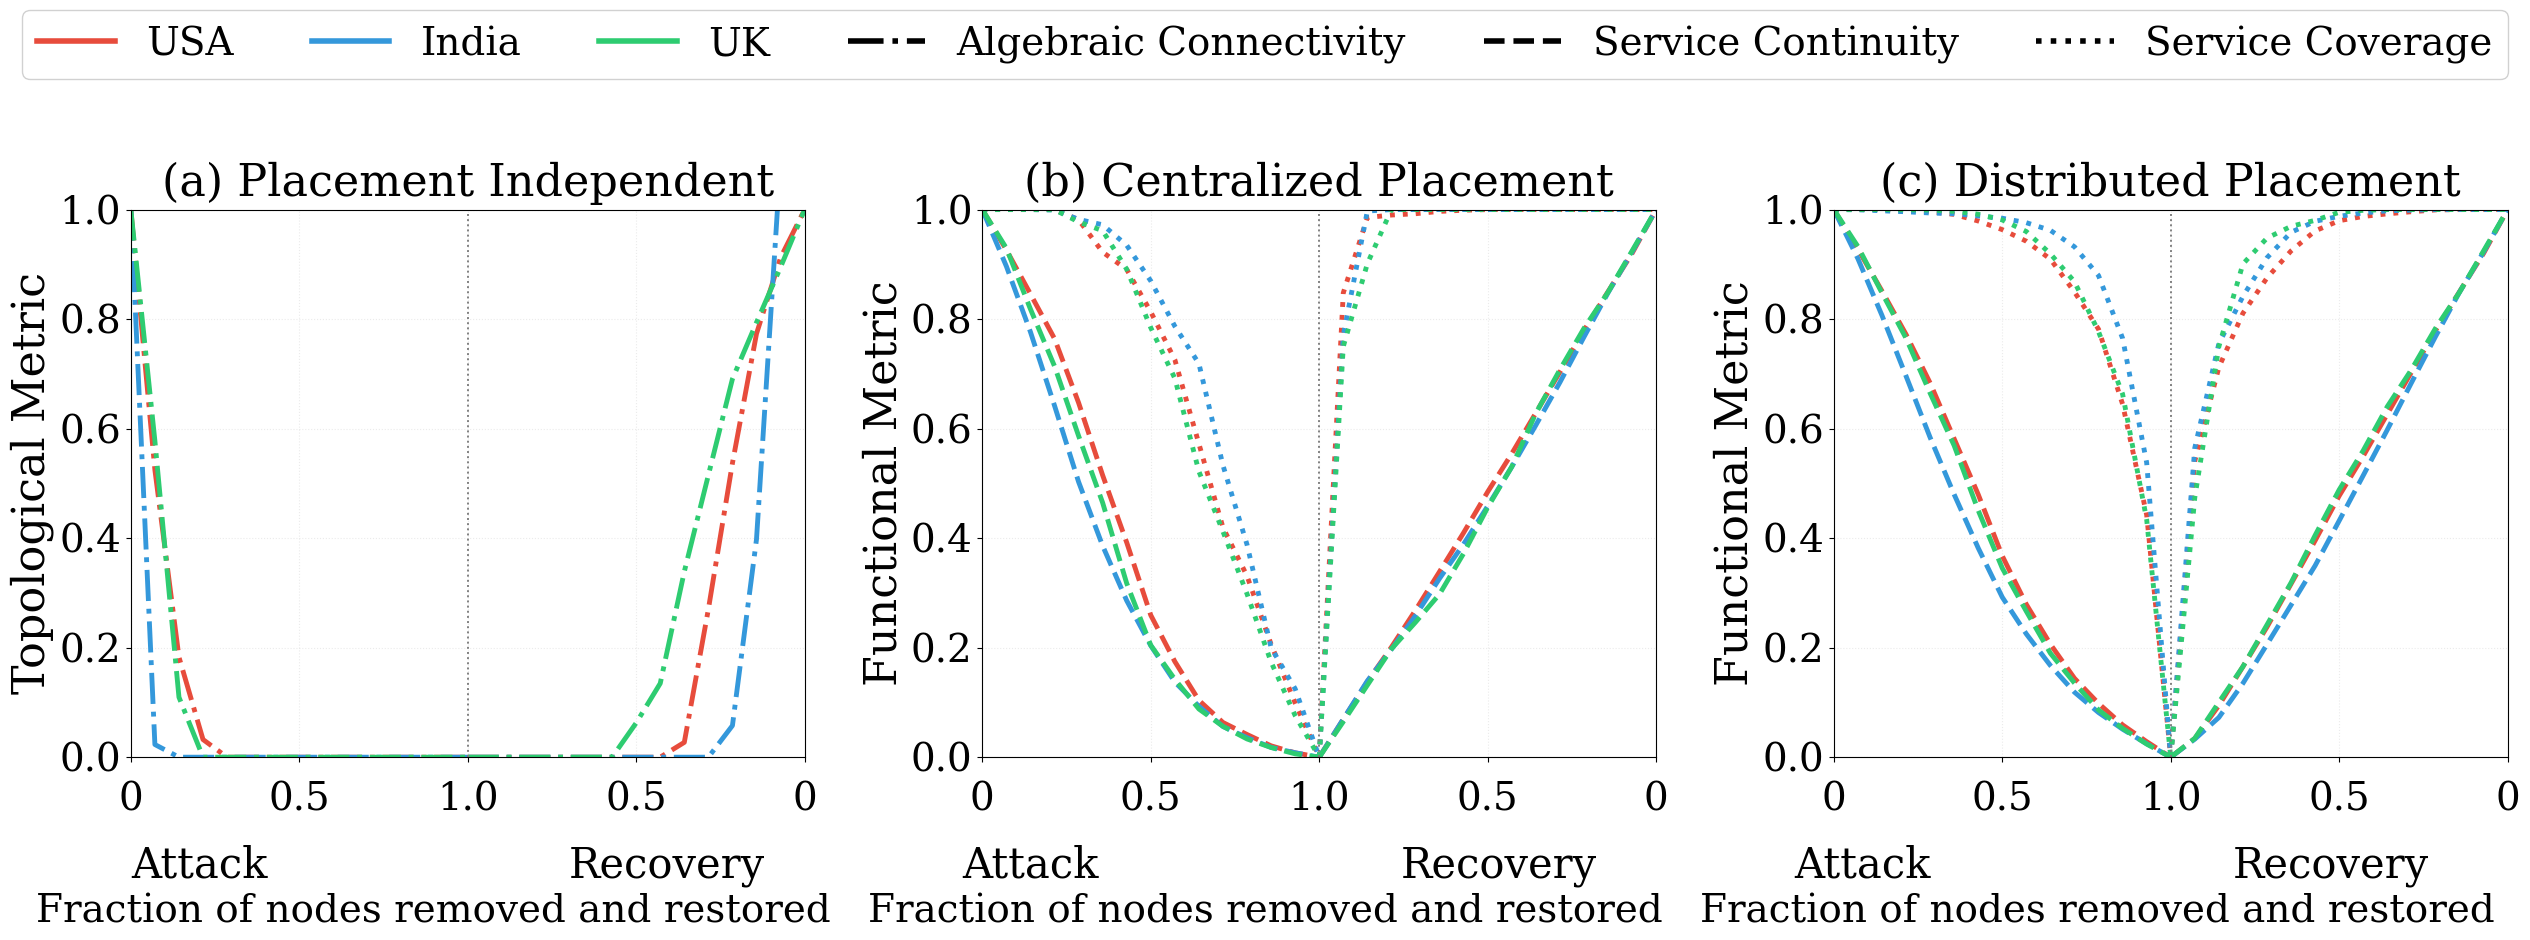

In [9]:

# =============================================================================
# RUN MONTE CARLO ATTACK–RECOVERY + SAVE RESULTS + PRINT ANALYSIS
# =============================================================================

def run_fire_attack_recovery_all(
    alpha: float = 1.5,
    n_runs: int = 50,
    ci_level: float = 95.0,
    results_dir: str = "results"
):
    """
    Driver for the full FIRE attack–recovery analysis:
      1. Runs simulations for G1 (US), G2 (India), G3 (UK)
      2. Summarises each topology into a CSV
      3. Prints FIRE FRAMEWORK ANALYSIS for each topology
      4. Returns all_results dict for plotting

    Assumes that:
      - G1, G2, G3
      - good_data_g1, poor_data_g1, etc.
    have been created in the Data Curation cell.
    """
    os.makedirs(results_dir, exist_ok=True)

    # Mapping from internal key to (label, topology ID, graph & data)
    topology_map = {
        "us":    ("USA Network",   "G1", G1, good_data_g1, poor_data_g1),
        "india": ("India Network", "G2", G2, good_data_g2, poor_data_g2),
        "uk":    ("UK Network",    "G3", G3, good_data_g3, poor_data_g3),
    }

    all_results = {}
    summaries = {}

    print("Running Monte Carlo Attack–Recovery Simulations")
    print("=" * 60)

    for key, (label, topo_id, G, good_data, poor_data) in topology_map.items():
        print(f"\n▶ {label} ({topo_id}): alpha={alpha}, n_runs={n_runs}")
        results = run_attack_recovery_simulation(
            G0=G,
            good_data=good_data,
            poor_data=poor_data,
            alpha=alpha,
            n_runs=n_runs
        )
        all_results[key] = results

        # Summarise + save CSV
        summary_df = summarize_attack_recovery_for_topology(results, ci_level=ci_level)
        summaries[topo_id] = summary_df

        csv_path = os.path.join(results_dir, f"{topo_id}_results.csv")
        summary_df.to_csv(csv_path, index=False)
        print(f"  ✓ Saved summary to {csv_path}")

        # Print FIRE framework analysis for this topology
        print_fire_framework_analysis(topo_id, summary_df)

    # Optionally: create OFC final camera-ready 3-panel figure
    try:
        print("\nGenerating OFC 3-panel attack–recovery figure...")
        plot_attack_recovery_final_camera(all_results)
    except Exception as e:
        print(f"Warning: plot_attack_recovery_final_camera failed: {e}")

    return all_results, summaries


# === Execute the full pipeline (this is your main 'simulation cell') ===
all_results, fire_summaries = run_fire_attack_recovery_all(
    alpha=1.5,
    n_runs=50,
    ci_level=95.0,
    results_dir="results"
)


In [10]:
# =============================================================================
# DOWNLOAD DATASETS AND RESULTS
# =============================================================================

import shutil
from google.colab import files

# Zip datasets
if os.path.isdir("datasets"):
    shutil.make_archive("datasets", "zip", "datasets")
    files.download("datasets.zip")
else:
    print("No 'datasets/' directory found – run the data curation cell first.")

# Zip results
if os.path.isdir("results"):
    shutil.make_archive("results", "zip", "results")
    files.download("results.zip")
else:
    print("No 'results/' directory found – run the simulation cell first.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>